## Exploration and classification of Student Responses to the PMQ(Physics Measurement Questionnaire) Using Logistic Regression

The PMQ is a survey given to physics students used to evaluate the student's reasoning about measurement uncertainty. The data available in this study is composed of ~2000 student responses from both Michigan State University and The University of Colorado Boulder to four probes on the PMQ: RD, UR, SMDS, and DMSS. In previous efforts these responses were coded and cross examined by researchers following a codebook<sup>[source]</sup> that separates student responses into two paradigms for measurement reasoning: setlike and pointlike. A third category, known as "undefined", was used when the student response did not reasonably fit into point-like or set-like, or if the response reasonably fit into both.

After using Natural Language Processing techniques to process the textual data, a One Vs Rest (OVR) logistic regression model is then fit to classify the student responses into one of the three possible categories(P, S or U). The OVR model is chosen because it achieved the highest performance on PMQ student response classification in a previous study<sup>[source]</sup>. The purpose of this study is to evaluate the "robustness", the applicability of the logistic regression classifier, across population differences. To accomplish this evaluation a logistic regression model is trained on each population(MSU and CU). Then, their performance metrics(Micro AUC of ROC curve, Cohen's Kappa) and most distinguishing words(highest weighted features) are compared across both populations. The models are considered robust if their performance metrics and distinguishing words are similar when tested on either population.




In [1]:
import numpy as np          #Scientific computing library for convenient math functions
import pandas as pd          #Contains pandas dataframes for easy data processing
import nltk                  #Natural Language Toolkit, for NLP
from nltk.corpus import stopwords          #Stopword list for text cleaning
from nltk.stem import WordNetLemmatizer          #Lemmatizer for text cleaning
from nltk.corpus import wordnet            #For part of speech tags, useful for the lemmatizer
import re                    #Regular expression library, useful for string manipulation such as removing punctuation
from sklearn.feature_extraction.text import TfidfVectorizer          #For Term Frequency - Inverse Document Frequency text conversion
import pickle                #For saving optimal models as pickle files 
import matplotlib.pyplot as plt          #Data visualization library 
from sklearn.linear_model import LogisticRegression          #Logistic regression model used
from sklearn.model_selection import train_test_split          #For equal splitting of the student response data into training and testing sets.
from sklearn.preprocessing import label_binarize               #Used to convert the testing labels to binary format i.e. P / S -> [1,0,0] / [0,1,0]
from sklearn.metrics import roc_curve, auc, confusion_matrix   #roc_curve is used to compute the roc curve(TPR and FPR) and auc() computes the integral 
                                                               #of the ROC curve using the trapezoidal rule. Confusion matrix to help with computing accuracy
                                                               #and cohen's kappa
%run PMQ_supervised_header.ipynb          #Useful functions specific to processing/visualizing the data structures in this analysis

# Processing PMQ Data from MSU

In this stage, the goals are to:
- Interpret the format of the csv data files received from MSU
- Extract pre and post test student responses and their assigned codes for each probe(RD,UR,SMDS,DMSS), compile these into one dataframe
- Visualize code distribution

In [2]:
RD_DATA = pd.read_csv("/mnt/data/pmq/msu/PMQ-PHY251-252-Final-RD.csv")
UR_DATA = pd.read_csv("/mnt/data/pmq/msu/PMQ-PHY251-252-Final-UR.csv")
DMSS_DATA = pd.read_csv("/mnt/data/pmq/msu/PMQ-PHY251-252-Final-DMSS.csv")
SMDS_DATA = pd.read_csv("/mnt/data/pmq/msu/PMQ-PHY251-252-Final-SMDS.csv")
RD_DATA.head()

,StudentID,CourseID,RD1.Pretest,RD2.Pretest,RD.CodePretest,RD1.Posttest,RD2.Posttest,RD.CodePosttest
0,A35606902,phy251-fa18,A,Scientific experiments rely on results being r...,P2,A,The more measurements the more accurate the re...,U3
1,A35606902,phy252-sp19,A,The more results the more accurate a trend can...,S3,A,It is better to have more data points from the...,"S1,S2"
2,A36582222,phy252-fa18,A,Replication of data results is needed to help ...,"S2,U2",A,There should be multiple data collected and th...,"P2,S2"
3,A40186500,phy252-fa18,A,What to make sure first role was not an outlie...,P2,A,Need to measure a few more times to make sure ...,P2
4,A42015415,phy252-fa18,A,Multiple trials allow you to calculate and exp...,S1,A,A few trials allows you to find an average and...,"S1,S2"


In [3]:
UR_DATA.head()

,StudentID,CourseID,UR1.Pretest,UR2.Pretest,UR.CodePretest,UR1.Posttest,UR2.Posttest,UR.CodePosttest
0,A35606902,phy251-fa18,432 mm,"It is the average of the 5 measurements, and t...",S6,They should take the mean of their results.,There is variation between the drops. The mos...,S3
1,A35606902,phy252-sp19,432,I think the mean is the best way to record the...,S3,432,That is the mean.,S1
2,A36582222,phy252-fa18,432mm,I calculated the average amongst the obtained ...,"S1,S5",432,I added up all the values for d and then divid...,S5
3,A40186500,phy252-fa18,434 mm,I would write down the median value of 434 mm ...,"P1,P3",432 mm,I just took the mean because in this survey at...,"S3,U1"
4,A42015415,phy252-fa18,Mean,Recording the average distance with an uncerta...,S4,432,"432 is that average and since results varied, ...",S4


It appears that the csv files have similar column names for each probe containing pre and post test data for PHY 251 & 252. RD1.test is the multiple choice response, RD2.test is the written student response, and RD.Code is the code given by the researcher. Now to combine this data into a single Pandas Dataframe

In [4]:
#Columns that are post test specific
RD_post_labels = ["StudentID","CourseID","RD1.Posttest","RD2.Posttest","RD.CodePosttest"]
UR_post_labels = ["StudentID","CourseID","UR1.Posttest","UR2.Posttest","UR.CodePosttest"]
DMSS_post_labels = ["StudentID","CourseID","DMSS1.Posttest","DMSS2.Posttest","DMSS.CodePosttest"]
SMDS_post_labels = ["StudentID","CourseID","SMDS1.Posttest","SMDS2.Posttest","SMDS.CodePosttest"]

#Columns that are pre test specific
RD_pre_labels = ["StudentID","CourseID","RD1.Pretest","RD2.Pretest","RD.CodePretest"]
UR_pre_labels = ["StudentID","CourseID","UR1.Pretest","UR2.Pretest","UR.CodePretest"]
DMSS_pre_labels = ["StudentID","CourseID","DMSS1.Pretest","DMSS2.Pretest","DMSS.CodePretest"]
SMDS_pre_labels = ["StudentID","CourseID","SMDS1.Pretest","SMDS2.Pretest","SMDS.CodePretest"]

#Creating separate pre and post dataframes
RD_DATA_pre = (RD_DATA.copy()).drop(columns = RD_post_labels)
UR_DATA_pre = (UR_DATA.copy()).drop(columns = UR_post_labels)
DMSS_DATA_pre = (DMSS_DATA.copy()).drop(columns = DMSS_post_labels)
SMDS_DATA_pre = (SMDS_DATA.copy()).drop(columns = SMDS_post_labels)

RD_DATA_post = (RD_DATA.copy()).drop(columns = RD_pre_labels)
UR_DATA_post = (UR_DATA.copy()).drop(columns = UR_pre_labels)
DMSS_DATA_post = (DMSS_DATA.copy()).drop(columns = DMSS_pre_labels)
SMDS_DATA_post = (SMDS_DATA.copy()).drop(columns = SMDS_pre_labels)

#Fixing codes so that they only display one, the rules when handling multiple codes is the following:
# P + S / S + P = U
# P/S + U = P/S
# U + P/S = U

RD_DATA_pre = fix_codes(RD_DATA_pre.copy())
UR_DATA_pre = fix_codes(UR_DATA_pre.copy())
DMSS_DATA_pre = fix_codes(DMSS_DATA_pre.copy())
SMDS_DATA_pre = fix_codes(SMDS_DATA_pre.copy())

RD_DATA_post = fix_codes(RD_DATA_post.copy())
UR_DATA_post = fix_codes(UR_DATA_post.copy())
DMSS_DATA_post = fix_codes(DMSS_DATA_post.copy())
SMDS_DATA_post = fix_codes(SMDS_DATA_post.copy())

#Fixing column names
RD_columns = ["RD_choice","RD_explanation","RD_Code"]
UR_columns = ["UR_choice","UR_explanation","UR_Code"]
DMSS_columns = ["DMSS_choice","DMSS_explanation","DMSS_Code"]
SMDS_columns = ["SMDS_choice","SMDS_explanation","SMDS_Code"]

RD_DATA_pre = pd.DataFrame(RD_DATA_pre.copy().values,columns = RD_columns)
UR_DATA_pre = pd.DataFrame(UR_DATA_pre.copy().values,columns = UR_columns)
DMSS_DATA_pre = pd.DataFrame(DMSS_DATA_pre.copy().values,columns = DMSS_columns)
SMDS_DATA_pre = pd.DataFrame(SMDS_DATA_pre.copy().values,columns = SMDS_columns)

RD_DATA_post = pd.DataFrame(RD_DATA_post.copy().values,columns = RD_columns)
UR_DATA_post = pd.DataFrame(UR_DATA_post.copy().values,columns = UR_columns)
DMSS_DATA_post = pd.DataFrame(DMSS_DATA_post.copy().values,columns = DMSS_columns)
SMDS_DATA_post = pd.DataFrame(SMDS_DATA_post.copy().values,columns = SMDS_columns)

#Concatenating into one data frame
FULL_DATA_pre = pd.concat([RD_DATA_pre.copy(),UR_DATA_pre.copy(),DMSS_DATA_pre.copy(),SMDS_DATA_pre.copy()],axis = 1).dropna()
FULL_DATA_post = pd.concat([RD_DATA_post.copy(),UR_DATA_post.copy(),DMSS_DATA_post.copy(),SMDS_DATA_post.copy()],axis = 1).dropna()
FULL_DATA_MSU = pd.concat([FULL_DATA_pre.copy(),FULL_DATA_post.copy()],axis = 0)

FULL_DATA_MSU.head()

,RD_choice,RD_explanation,RD_Code,UR_choice,UR_explanation,UR_Code,DMSS_choice,DMSS_explanation,DMSS_Code,SMDS_choice,SMDS_explanation,SMDS_Code
0,A,Scientific experiments rely on results being r...,P,432 mm,"It is the average of the 5 measurements, and t...",S,A,The results are still very close.,P,B,It is important to collect data from both grou...,U
1,A,The more results the more accurate a trend can...,S,432,I think the mean is the best way to record the...,S,A,The results are pretty close.,P,A,"smaller data range, but they all should be rec...",S
2,A,Replication of data results is needed to help ...,S,432mm,I calculated the average amongst the obtained ...,S,B,"I would agree with Group B, because the averag...",P,A,Although both groups repeated the releases 5 d...,S
3,A,What to make sure first role was not an outlie...,P,434 mm,I would write down the median value of 434 mm ...,P,A,Each group would have to calculate the error i...,S,A,While the average is the same between the two ...,S
4,A,Multiple trials allow you to calculate and exp...,S,Mean,Recording the average distance with an uncerta...,S,A,Results are close considering range of overall...,S,B,If only concerned with the average of the data...,P


In [5]:
len(FULL_DATA_MSU)

2373

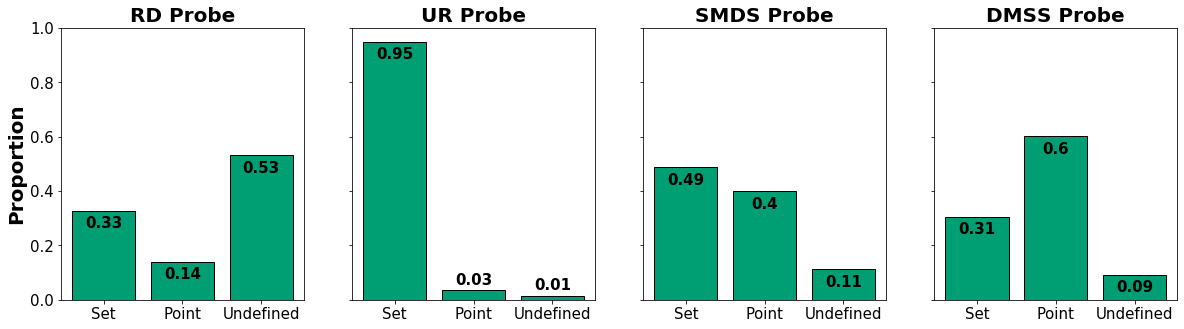

In [6]:
#Visualizing the distribution of coded responses for each probe 
fig,ax = plt.subplots(1,4,figsize=(20,5), sharey=True)
classes = ['S', 'P', 'U']
probe_list = ["RD","UR","SMDS","DMSS"]
for i,probe in enumerate(probe_list):
    x_pos = np.arange(0,3,1)
    width = .8
    #actual
    probe_code = probe + "_Code"
    y_pos = [(list(FULL_DATA_MSU[probe_code]).count(c)) / len(FULL_DATA_MSU[probe_code]) for c in classes]
    ax[i].set_ylim(0,1)
    rect_act = ax[i].bar(x_pos, y_pos, width, tick_label=['Set-Like', 'Point-Like', 'Undefined'], edgecolor='black', color = "#009E73")
    if i == 0:
        ax[i].set_ylabel('Proportion', fontsize = 20, fontweight = "bold")
    ax[i].tick_params(labelsize = 15)
    ax[i].set_title(f'{probe} Probe', fontsize = 20, fontweight = "bold")
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(['Set', 'Point', 'Undefined'])
    
    for j, prop in enumerate(y_pos):
        if prop > .06:
            va = 'top'
            offset = -.02
        else:
            va = 'bottom'
            offset = + .01
        ax[i].text(x_pos[j], #X location of proportion
                prop + offset, #Y location
                s=f'{round(prop,2)}', #Required label with formatting
                fontweight = "bold",
                va=va, #Vertical alignment
                ha='center', #Horizontal alignment
                color='black', #Font colour and size
                fontsize=15
                )
    
#plt.suptitle("Distribution of Coded Student Responses MSU")
plt.savefig("Distribution of Coded Student Responses MSU")

# Processing PMQ Data from CU

In this stage, the goals are to:
- Interpret the format of the csv data files received from CU
- Extract pre and post test student responses and their assigned codes for each probe(RD,UR,SMDS,DMSS), compile these into one dataframe

In [7]:
#Run this cell to use CU data

#Load in data as a Pandas Dataframe, explore what each file contains
PMQ_DATA_raw = pd.read_csv("/mnt/data/pmq/CUdata/PMQ_rawData.csv",header = 1)
PMQ_DATA_code_clean = pd.read_csv("/mnt/data/pmq/CUdata/rawData_coding_cleaned_matched.csv")
PMQ_DATA_code = pd.read_csv("/mnt/data/pmq/CUdata/rawData_coding.csv")

print(f"Number of entries: {len(PMQ_DATA_raw)}")
PMQ_DATA_raw.head()

Number of entries: 3712


,Primary Index,Rand Index,RD choice,RD explanation,UR choice,UR explanation,SMDS choice,SMDS explanation,DMSS choice,DMSS explanation,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,1,378649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,612549,A,"There could be random errors, you need more data",432,Average,A,Smaller error,A,"Same spread in the data, within a few mm of on...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,726654,A,To account for human error,432,That's the average of the five,B,because the average is the same and there migh...,A,BC the average is close enough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,239593,A,Reduce uncertainty,432 pm 4,That captures most of the data,C,B had a smaller range of numbers,A,Both around the same average with similar unce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,440807,A,The more data you have the more evidence you h...,432,Average of the data,B,You can't tell whose is tighter data without l...,A,Depending on the stdev they could all technica...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(f"Number of entries: {len(PMQ_DATA_code)}")
PMQ_DATA_code.head()

Number of entries: 2465


,Rand Index,RD Code,UR Code,SMDS Code,DMSS Code
0,883194,P1,U2,S2,S1
1,300076,P1,S1,S2,S3
2,260634,P1,S2,S1,U4
3,919428,P1,S4,S3,S3
4,407042,P1,S1,P1,S3


In [9]:
print(f"Number of entries: {len(PMQ_DATA_code_clean)}")
PMQ_DATA_code_clean.head()

Number of entries: 2076


,randIndex,RD,UR,SMDS,DMSS,semester,match
0,883194,P1,U2,S2,S1,S18Pre,350548
1,300076,P1,S1,S2,S3,S17Pre,40500
2,260634,P1,S2,S1,U4,S17Pre,488703
3,919428,P1,S4,S3,S3,S17Pre,984262
4,407042,P1,S1,P1,S3,S18Pre,406263




It looks like PMQ_rawData.csv contains all of the textual student response data, rawData_coding.csv contains the 
uncleaned codes given to each student response and rawData_coding_cleaned_matched.csv contains the cleaned codes along with the semester information. To match the same student to their pre and post test responses, each entry of
rawData_coding_cleaned_matched.csv contains a matching number which is the randIndex that its matching response corresponds
to. Since we want a variety of student responses to the PMQ, pre and post test data will not be distinguished and
combined into one dataframe.

In [10]:
#Removing the empty columns in PMQ_rawData.csv
empty_cols = ["Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16", "Unnamed: 17", "Unnamed: 18"]
PMQ_DATA_raw = PMQ_DATA_raw.drop(empty_cols, axis = 1)

#PMQ_DATA_raw = PMQ_DATA_raw.dropna() Don't use, this command causes rows that contain RD post test data but NOT pre test data to be deleted.



#The following lines extracts the cleaned coded random indexes to select only student responses that have been cleaned
#To follow the format for previous cleaning methods, pre and post data will be separated at this stage.
ridx = "randIndex"
PMQ_coded_pre_idx = []
PMQ_coded_post_idx = []

for rand_idx in PMQ_DATA_code_clean[ridx]:
    if (PMQ_DATA_code_clean[PMQ_DATA_code_clean[ridx] == rand_idx])["semester"].iloc[0][3:] == "Pre":
        PMQ_coded_pre_idx.append(rand_idx)
    elif (PMQ_DATA_code_clean[PMQ_DATA_code_clean[ridx] == rand_idx])["semester"].iloc[0][3:] == "Post":
        PMQ_coded_post_idx.append(rand_idx)
    else:
        print((PMQ_DATA_code_clean[PMQ_DATA_code_clean[ridx] == rand_idx])["semester"].iloc[0][3:])

#Masking the cleaned codes for the pre and post responses
PMQ_DATA_pre_codes = PMQ_DATA_code_clean[PMQ_DATA_code_clean[ridx].isin(PMQ_coded_pre_idx)]
PMQ_DATA_post_codes = PMQ_DATA_code_clean[PMQ_DATA_code_clean[ridx].isin(PMQ_coded_post_idx)]

#Creating the rows of the combined dataframe. Each row will have the following format:
#rand_idx semester pre-MC pre-response pre-code post-MC post-response post-code 

RD_DATA = []
UR_DATA = []
DMSS_DATA = []
SMDS_DATA = []

for idx in PMQ_coded_pre_idx:
    #Extract each relevant row to the index for the pre test response
    code_row_pre = PMQ_DATA_pre_codes[PMQ_DATA_pre_codes["randIndex"] == idx]
    raw_row_pre = PMQ_DATA_raw[PMQ_DATA_raw["Rand Index"] == idx]
    #Match up the pre index with the post index, extract post rows
    code_row_post = PMQ_DATA_post_codes[PMQ_DATA_post_codes["randIndex"] == code_row_pre["match"].iloc[0]]
    raw_row_post = PMQ_DATA_raw[PMQ_DATA_raw["Rand Index"] == code_row_pre["match"].iloc[0]]
    #Format for semester will be S#pre,S#post
    semester = code_row_pre["semester"].iloc[0] + ',' + code_row_post["semester"].iloc[0]
    
    #Create each row of dataframes
    RD_row = [idx, semester, raw_row_pre["RD choice"].iloc[0], raw_row_pre["RD explanation"].iloc[0], code_row_pre["RD"].iloc[0], raw_row_post["RD choice"].iloc[0], 
              raw_row_post["RD explanation"].iloc[0], code_row_post["RD"].iloc[0]]
    
    UR_row = [idx, semester, raw_row_pre["UR choice"].iloc[0], raw_row_pre["UR explanation"].iloc[0], code_row_pre["UR"].iloc[0], raw_row_post["UR choice"].iloc[0], 
              raw_row_post["UR explanation"].iloc[0], code_row_post["UR"].iloc[0]]
    
    DMSS_row = [idx, semester, raw_row_pre["DMSS choice"].iloc[0], raw_row_pre["DMSS explanation"].iloc[0], code_row_pre["DMSS"].iloc[0], raw_row_post["DMSS choice"].iloc[0],
                raw_row_post["DMSS explanation"].iloc[0], code_row_post["DMSS"].iloc[0]]
    
    SMDS_row = [idx, semester, raw_row_pre["SMDS choice"].iloc[0], raw_row_pre["SMDS explanation"].iloc[0], code_row_pre["SMDS"].iloc[0], raw_row_post["SMDS choice"].iloc[0], 
                raw_row_post["SMDS explanation"].iloc[0], code_row_post["SMDS"].iloc[0]]
    
    #Append each row to a list that will be converted into a Pandas Dataframe.
    RD_DATA.append(RD_row)
    UR_DATA.append(UR_row)
    DMSS_DATA.append(DMSS_row)
    SMDS_DATA.append(SMDS_row)
    
#These column names match the columns names of the MSU dataset, which saves rewriting existing cleaning routines.

RD_columns = ["StudentID", "CourseID", "RD1.Pretest", "RD2.Pretest", "RD.CodePretest", "RD1.Posttest", "RD2.Posttest", "RD.CodePosttest"]
UR_columns = ["StudentID", "CourseID", "UR1.Pretest", "UR2.Pretest", "UR.CodePretest", "UR1.Posttest", "UR2.Posttest", "UR.CodePosttest"]
DMSS_columns = ["StudentID", "CourseID", "DMSS1.Pretest", "DMSS2.Pretest", "DMSS.CodePretest", "DMSS1.Posttest", "DMSS2.Posttest", "DMSS.CodePosttest"]
SMDS_columns = ["StudentID", "CourseID", "SMDS1.Pretest", "SMDS2.Pretest", "SMDS.CodePretest", "SMDS1.Posttest", "SMDS2.Posttest", "SMDS.CodePosttest"]

#Create the dataframes for each probe
RD_DATA = pd.DataFrame(RD_DATA,columns = RD_columns)
UR_DATA = pd.DataFrame(UR_DATA,columns = UR_columns)
DMSS_DATA = pd.DataFrame(DMSS_DATA, columns = DMSS_columns)
SMDS_DATA = pd.DataFrame(SMDS_DATA,columns = SMDS_columns)

#Print out to ensure nothing looks fishy
RD_DATA.head()

,StudentID,CourseID,RD1.Pretest,RD2.Pretest,RD.CodePretest,RD1.Posttest,RD2.Posttest,RD.CodePosttest
0,883194,"S18Pre,S18Post",A,to make sure the number is correct,P1,A,I think he is right,U1
1,300076,"S17Pre,S17Post",A,Replication is important to ensure your result...,P1,A,replication\n,U1
2,260634,"S17Pre,S17Post",A,repeating helps confirms results,P1,A,less error,U2
3,919428,"S17Pre,S17Post",A,you want to make sure your results are repeata...,P1,A,We need to make sure our result is repeatable ...,U3
4,407042,"S18Pre,S18Post",A,Checking your answer makes it easier to prove,P1,A,the more times the experiment is completed the...,S4


In [11]:
#Now to concatenate all of the probe data into one dataframe 

#Creating separate pre and post dataframes
RD_DATA_pre = (RD_DATA.copy()).drop(columns = RD_post_labels)
UR_DATA_pre = (UR_DATA.copy()).drop(columns = UR_post_labels)
DMSS_DATA_pre = (DMSS_DATA.copy()).drop(columns = DMSS_post_labels)
SMDS_DATA_pre = (SMDS_DATA.copy()).drop(columns = SMDS_post_labels)

RD_DATA_post = (RD_DATA.copy()).drop(columns = RD_pre_labels)
UR_DATA_post = (UR_DATA.copy()).drop(columns = UR_pre_labels)
DMSS_DATA_post = (DMSS_DATA.copy()).drop(columns = DMSS_pre_labels)
SMDS_DATA_post = (SMDS_DATA.copy()).drop(columns = SMDS_pre_labels)

#Fixing codes so that they only display one, the rules when handling multiple codes is the following:
# P + S / S + P = U
# P/S + U = P/S
# U + P/S = U

RD_DATA_pre = fix_codes(RD_DATA_pre.copy())
UR_DATA_pre = fix_codes(UR_DATA_pre.copy())
DMSS_DATA_pre = fix_codes(DMSS_DATA_pre.copy())
SMDS_DATA_pre = fix_codes(SMDS_DATA_pre.copy())

RD_DATA_post = fix_codes(RD_DATA_post.copy())
UR_DATA_post = fix_codes(UR_DATA_post.copy())
DMSS_DATA_post = fix_codes(DMSS_DATA_post.copy())
SMDS_DATA_post = fix_codes(SMDS_DATA_post.copy())

#Fixing column names
RD_columns = ["RD_choice","RD_explanation","RD_Code"]
UR_columns = ["UR_choice","UR_explanation","UR_Code"]
DMSS_columns = ["DMSS_choice","DMSS_explanation","DMSS_Code"]
SMDS_columns = ["SMDS_choice","SMDS_explanation","SMDS_Code"]

RD_DATA_pre = pd.DataFrame(RD_DATA_pre.copy().values,columns = RD_columns)
UR_DATA_pre = pd.DataFrame(UR_DATA_pre.copy().values,columns = UR_columns)
DMSS_DATA_pre = pd.DataFrame(DMSS_DATA_pre.copy().values,columns = DMSS_columns)
SMDS_DATA_pre = pd.DataFrame(SMDS_DATA_pre.copy().values,columns = SMDS_columns)

RD_DATA_post = pd.DataFrame(RD_DATA_post.copy().values,columns = RD_columns)
UR_DATA_post = pd.DataFrame(UR_DATA_post.copy().values,columns = UR_columns)
DMSS_DATA_post = pd.DataFrame(DMSS_DATA_post.copy().values,columns = DMSS_columns)
SMDS_DATA_post = pd.DataFrame(SMDS_DATA_post.copy().values,columns = SMDS_columns)

#Concatenating into one data frame
FULL_DATA_pre = pd.concat([RD_DATA_pre.copy(),UR_DATA_pre.copy(),DMSS_DATA_pre.copy(),SMDS_DATA_pre.copy()],axis = 1).dropna()
FULL_DATA_post = pd.concat([RD_DATA_post.copy(),UR_DATA_post.copy(),DMSS_DATA_post.copy(),SMDS_DATA_post.copy()],axis = 1).dropna()
FULL_DATA_CU = pd.concat([FULL_DATA_pre.copy(),FULL_DATA_post.copy()],axis = 0)

FULL_DATA_CU.head()

,RD_choice,RD_explanation,RD_Code,UR_choice,UR_explanation,UR_Code,DMSS_choice,DMSS_explanation,DMSS_Code,SMDS_choice,SMDS_explanation,SMDS_Code
0,A,to make sure the number is correct,P,430,because it is closer to the average,U,A,you can not control the uncertainty,S,A,all answers are in range of 20 so it is the mo...,S
1,A,Replication is important to ensure your result...,P,432,The average of the results.,S,A,Calculating the error probably leads to the gr...,S,A,"Group A has a lower error/uncertainty, so the ...",S
2,A,repeating helps confirms results,P,average of the trials,tells all results,S,A,math,U,A,more precise,S
3,A,you want to make sure your results are repeata...,P,432 +- standard deviation,I took the average for d then you should alway...,S,A,both groups answers deviate more than their av...,S,A,A had more precise measurements and probably m...,S
4,A,Checking your answer makes it easier to prove,P,432,The answer should be an average of all the exp...,S,A,There is a very small range of error so both a...,S,B,The results come up with around the same answer,P


In [12]:
len(FULL_DATA_CU)

1998

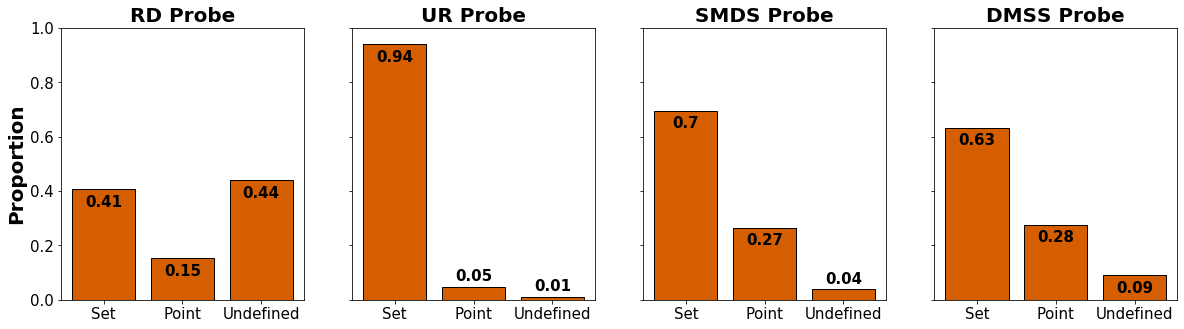

In [13]:
#Visualizing the distribution of coded responses for each probe    
fig,ax = plt.subplots(1,4,figsize=(20,5), sharey=True)
classes = ['S', 'P', 'U']
probe_list = ["RD","UR","SMDS","DMSS"]
for i,probe in enumerate(probe_list):
    x_pos = np.arange(0,3,1)
    width = .8
    #actual
    probe_code = probe + "_Code"
    y_pos = [(list(FULL_DATA_CU[probe_code]).count(c)) / len(FULL_DATA_CU[probe_code]) for c in classes]
    ax[i].set_ylim(0,1)
    rect_act = ax[i].bar(x_pos, y_pos, width, tick_label=['Set-Like', 'Point-Like', 'Undefined'], edgecolor='black', color = "#D55E00")
    if i == 0:
        ax[i].set_ylabel('Proportion', fontsize = 20, fontweight = "bold")
    ax[i].tick_params(labelsize = 15)
    ax[i].set_title(f'{probe} Probe', fontsize = 20, fontweight = "bold")
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(['Set', 'Point', 'Undefined'])
    
    for j, prop in enumerate(y_pos):
        if prop > .06:
            va = 'top'
            offset = -.02
        else:
            va = 'bottom'
            offset = + .01
        ax[i].text(x_pos[j], #X location of proportion
                prop + offset, #Y location
                s=f'{round(prop,2)}', #Required label with formatting
                fontweight = "bold",
                va=va, #Vertical alignment
                ha='center', #Horizontal alignment
                color='black', #Font colour and size
                fontsize=15
                )
    
    
    
#plt.suptitle("Distribution of Coded Student Responses CU")
plt.savefig("Distribution of Coded Student Responses CU")

# Training The OVR Logistic Regression Models

In this step OVR logistic regression models to classify PMQ student data into the point/set paradigm are built by training the models separately on MSU and CU data. The metric that will be used to indicate whether our model is achieving good performance will be the Area Under the Curve(AUC) of the Response Operator Characteristic(ROC) curve. 

### Natural Language Processing

Natural Language Processing(NLP) techniques help to improve the interpretability of textual data to computational modelling techniques. The techniques applied to the student responses before they are used to train the logistic regression model are the following:

1. Removal of stop words - Removing words that don't hold much semantic meaning on their own i.e. the, and, because, them
2. Lemmatization - Reducing words to their stems i.e. measured/measures -> measure
3. Removal of Punctuation

To convert the words in the student responses to a data structure that a logistic model can understand, each response is converted into a vector of size V with each entry corresponding to a word in the vocabularly, with V being the size of the vocabularly. The value of each entry is the term frequency of the word in the response(TF) multiplied by the inverse document frequency(IDF). This is known as the TF-IDF value for each word and is calculated as follows:

$TF-IDF(w) = R_f(w) * log(\frac{N_d}{d_f(w)})$

Where w is the word, R_f(w) is the word's frequency in the response, N_d is the number of documents and d_f(w) is the number of documents containing w. This metric weights each word proportional to its prevalence in the response and inversely proportional to how common it is accross all responses, aiming to make words important and unique to the response to have more sway over the classification of the response. Once the data is processed through these steps, it is fed to the logistic regression model to be trained. 

### OVR Logistic Regression

The One Vs Rest(OVR) framework is a natural extension of binary classifiers to allow them to handle multip labelled data. In OVR, a binary classifier is trained for each label to determine how likely that the datapoint belongs to the label vs how likely it doesn't belong to the label. In OVR logistic regression, given N different labels, N different models are created, one for each label. When classifying a datapoint, each of the N logistic regression models are tested on the data point and the label paired with the model with the highest probability output is given to the datapoint. In this analysis, the student responses represent the datapoints and the codes given to them(P, S, or U) represent the labels. Therefore, when applying OVR logistic regression to this dataset a separate logistic regression model is trained for each label. 

OVR has an additional advantage specific to this dataset. Unlike its multinomial counterpart which assumes the independence of irrelevant alternatives, OVR logistic regression distinguishes each label from *all* possible labels. Since codebooks are not the ground truth and the coders are making various choices when identifying a response, limiting the classifier to only consider labels defined by the codebook can fail to capture actuality.  

### Model Validation
One metric that will be used to indicate whether our model is achieving good performance will be the Area Under the Curve(AUC) of the Response Operator Characteristic(ROC) curve. The ROC curve is a plot of the True Positive Rate(TPR) vs. the False Positive Rate(FPR) obtained by varying the threshold decision score needed for a positive classification. Well performing models will yield high TPRs with low FPRs for a wide range of decision thresholds, thus well performing models will tend towards the the top-left corner of the TPR-FPR axes(TPR ~1 FPR ~0). This makes the area under the ROC curve a reasonable metric for model performance.

Since three classifications are predicted by the OVR logistic regression model, three decision scores are given for each classification are outputted for each student response. This results in three different ROC curves, one each for the point-like, set-like, and undefined classifications. Because there are multiple curves, judging a model by just one of them will be a biased metric of the model's overall performance. A reasonable approach would be to take the average AUC across the three ROC curves(Macro AUC) as the evaluation metric, but this has the weakness of unfairly judging the model's performance on classification categories with fewer examples in the training data compared to the rest, such as the undefined classification in the SMDS and DMSS probes. For this reason, the proportional average of the three AUCs(Micro AUC) is used as the evaluation metric. The macro ROC curve is found by linearly interpolating the TPRs for each individual ROC curve to the full combined FPR space so that and then averaging the three. The Micro AUC is found by first converting each prediction to three separate predictions for each classification, aggregating these predictions with their corresponding decision probabilities to one set, and creating an ROC curve by varying the decision threshold on this new set. This ensures that each classification impacts the AUC proportional to their prevalence in the training set. 

Another metric that will be computed will be Cohen's Kappa and the accuracy. Cohen's Kappa accounts for the the fact that the model can predict a correct classification through random chance and is good for use in imbalanced datasets for this very reason, for datasets with highly imbalance datasets are predicted quite well if the model simply just assumes that each response is belonging to the most prevalent classification. The formula for Cohen's Kappa is as follows and can be calculated directly from the confusion matrix:

$\kappa = \frac{Acc - C}{1 - C}$

Where Acc is the accuracy of the model and C is the probability that the model predicts a response correctly by chance. C is calculated as the following:

$C = \frac{N_p}{N}*\frac{P_p}{N} + \frac{N_s}{N}*\frac{P_s}{N} + \frac{N_u}{N}*\frac{P_u}{N}$

Where N is the total number of responses, N_p, N_s, and N_u are the total number of point-like, set-like, and undefined responses. P_p, P_s, P_u are the total number of predicted point-like, set-like, and undefined responses. 

To deal with the inherit randomness that exists when the data is split, multiple(250) models will be trained on each probe on each dataset. To best assess how each model is performing and to increase the reproducibility of these results, the AUC(s) of all models are evaluated on their corresponding testing sets and the mean with its 95% confidence interval are measured. This approach gives a more honest assessement of the model's performance since it deals with the chance that a particular split of the data results in a much higher(or much lower) performance than the other splits. When choosing the best model out of the 250 trained, the model with the highest AUC is chosen.


Since the UR probe data on both datasets(MSU and CU) is highly imbalanced, meaning that the amount of instances of each classification are disproportionate with each other, this probe will not be modeled. 

In [14]:
#MSU first

iterations = 500             #Number of splits
n_classes = 3               #Number of classifications(P S and U)
MSU_model_dict = {}         #Dictionary containing the model results for each different split of the data

for itr in range(0,iterations):
    FULL_train, FULL_test = train_test_split(FULL_DATA_MSU.copy(), test_size=0.2)        #Splits the data into training and testing sets 80-20
                                                                                     #while retaining the classification proportion

    FULL_train = (FULL_train.copy()).reset_index(drop = True) #Resetting indexes that carried over
    FULL_test = (FULL_test.copy()).reset_index(drop = True)

    train_text = clean_text(FULL_train)               #Cleaning the text 
    train_labels = get_labels(FULL_train)             #extracting the classifications from the training set
    train_labels, train_text = clean_nans(train_labels, train_text)  #Missing labels sometimes occur, these are removed in this line
    
    #Do the same for the testing data
    test_text = clean_text(FULL_test)
    test_labels = get_labels(FULL_test)
    test_labels, test_text = clean_nans(test_labels,test_text)

    OVR_models = {}       #Model metric dictionary for current run, added to MSU_model_dict.
    probes = ["RD","SMDS","DMSS"]
    
    #Assigning keys for each metric for each probe.
    for probe in probes:
        OVR_models[probe] = {}

    for probe in probes:
        OVR_models[probe]["TPR"] = {}
        OVR_models[probe]["FPR"] = {}
        OVR_models[probe]["AUC"] = {}

    #Converting the cleaned text data into TF-IDF format
    train_vector, classify_vector,v_dict = train_vectorize(train_text, test_text)
    
    #Training the models for each probe and classifying the testing set using the models.
    classify_dict, models = train_classify_ovr(classify_vector, train_vector, 
                                                   train_labels)

    
    for probe in probes:
        predicted = models[probe].predict_proba(classify_vector[probe])
        OVR_models[probe]["vectorizer"] = v_dict[probe]
        OVR_models[probe]["test_text"] = test_text[probe]
        OVR_models[probe]["Model"] = models[probe]
        OVR_models[probe]["prob_scores"] = np.array(predicted)
        OVR_models[probe]["test_results"] = classify_dict[probe]
        OVR_models[probe]["vocab"] = v_dict[probe].vocabulary_

    #Converting the responses to binary format
    test_labels_binary = {}
    test_labels_binary["RD"] = label_binarize(test_labels["RD"], classes = ['P','S','U']) #Make each label [1,0,0] for P and so on
    test_labels_binary["SMDS"] = label_binarize(test_labels["SMDS"], classes = ['P','S','U'])
    test_labels_binary["DMSS"] = label_binarize(test_labels["DMSS"], classes = ['P','S','U'])
    
    #Compute the TPR and FPR achieved by varying the decision threshold for each classification's ROC curve
    for probe in probes:
        test_scores = OVR_models[probe]['prob_scores']
        OVR_models[probe]["test_labels"] = test_labels_binary[probe]
        OVR_models[probe]["test_labels_nb"] = test_labels[probe]
        for i,code in [(0,'P'), (1,'S'), (2,'U')]:
            OVR_models[probe]["FPR"][code], OVR_models[probe]["TPR"][code], _ = roc_curve(test_labels_binary[probe][:,i], test_scores[:, i])
            OVR_models[probe]["AUC"][code] = auc(OVR_models[probe]["FPR"][code], OVR_models[probe]["TPR"][code])
        
        #Computing the micro FPR, TPR, and auc by raveling the labels and decision probabilities together
        OVR_models[probe]["FPR"]["micro"], OVR_models[probe]["TPR"]["micro"], _ = roc_curve(test_labels_binary[probe].ravel(), test_scores.ravel())
        OVR_models[probe]["AUC"]["micro"] = auc(OVR_models[probe]["FPR"]["micro"], OVR_models[probe]["TPR"]["micro"])
    
        #Computing the macro auc 
        #First concatenate the entire FPR space across each classification
        combined_fpr = np.unique(np.concatenate([OVR_models[probe]["FPR"][code] for code in ['P','S','U']]))

        #Then linearly interpolate the TPRs for each classification to the new FPR space
        mean_tpr = np.zeros_like(combined_fpr)
        for code in ['P','S','U']:
            mean_tpr += np.interp(combined_fpr, OVR_models[probe]["FPR"][code], OVR_models[probe]["TPR"][code])

        #Finally average it and compute macro AUC
        mean_tpr /= n_classes
        
        OVR_models[probe]["FPR"]["macro"] = combined_fpr
        OVR_models[probe]["TPR"]["macro"] = mean_tpr
        
        OVR_models[probe]["AUC"]["macro"] = auc(OVR_models[probe]["FPR"]["macro"],OVR_models[probe]["TPR"]["macro"])
        
        #Compute accuracy and cohen's kappa for each probe
        
        #First compute the confusion matrix, M[i,j] is how many i classifications are predicted to be j. 0:P, 1:S, 2:U
        #test_results_binary = label_binarize(OVR_models[probe]["test_results"], classes = ['P','S','U'])
        conf_matr = confusion_matrix(test_labels[probe],OVR_models[probe]["test_results"],labels = ['P','S','U'])
        
        #Accuracy is just the trace divided by the lump sum of each entry
        N = np.sum(conf_matr.ravel())
        TP = np.trace(conf_matr)
        OVR_models[probe]["Acc"] = TP / N
        
        #Calculating the estimated chance agreement
        C = 0
        for i in range(len(conf_matr)):
            N_i = conf_matr[i,:].sum()  #Number of classifications
            P_i = conf_matr[:,i].sum()  #Number of predicted classifications
            C += N_i/N * P_i/N          #ith term of chance agreement
            
        K = ( (TP / N) - C ) / ( 1 - C )
        OVR_models[probe]["Kappa"] = K
        
            
        
        
        
        
        
    MSU_model_dict[itr] = OVR_models
    if itr%10 == 0:
        print(f"Progress: {itr}/{iterations}")

#Collecting the cohen kappas and micro aucs for each probe into pandas series objects
#Collecting the cohen kappas and micro, P, S, and U aucs for each probe and converting into pandas series objects
MSU_kappas = {}
MSU_micros = {}
MSU_P = {}
MSU_S = {}
MSU_U = {}

for probe in probes:
    kappas = []
    micros = []
    P = []
    S = []
    U = []
    for itr in range(0,iterations):
        kappas.append(MSU_model_dict[itr][probe]["Kappa"])
        micros.append(MSU_model_dict[itr][probe]["AUC"]["micro"])
        P.append(MSU_model_dict[itr][probe]["AUC"]["P"])
        S.append(MSU_model_dict[itr][probe]["AUC"]["S"])
        U.append(MSU_model_dict[itr][probe]["AUC"]["U"])
        
    MSU_kappas[probe] = pd.Series(kappas)
    MSU_micros[probe] = pd.Series(micros)
    MSU_P[probe] = pd.Series(P)
    MSU_S[probe] = pd.Series(S)
    MSU_U[probe] = pd.Series(U)

Progress: 0/500
Progress: 10/500
Progress: 20/500
Progress: 30/500
Progress: 40/500
Progress: 50/500
Progress: 60/500
Progress: 70/500
Progress: 80/500
Progress: 90/500
Progress: 100/500
Progress: 110/500
Progress: 120/500
Progress: 130/500
Progress: 140/500
Progress: 150/500
Progress: 160/500
Progress: 170/500
Progress: 180/500
Progress: 190/500
Progress: 200/500
Progress: 210/500
Progress: 220/500
Progress: 230/500
Progress: 240/500
Progress: 250/500
Progress: 260/500
Progress: 270/500
Progress: 280/500
Progress: 290/500
Progress: 300/500
Progress: 310/500
Progress: 320/500
Progress: 330/500
Progress: 340/500
Progress: 350/500
Progress: 360/500
Progress: 370/500
Progress: 380/500
Progress: 390/500
Progress: 400/500
Progress: 410/500
Progress: 420/500
Progress: 430/500
Progress: 440/500
Progress: 450/500
Progress: 460/500
Progress: 470/500
Progress: 480/500
Progress: 490/500


In [15]:
#Now CU
            #Number of splits
n_classes = 3               #Number of classifications(P S and U)
CU_model_dict = {}         #Dictionary containing the model results for each different split of the data

for itr in range(0,iterations):
    FULL_train, FULL_test = train_test_split(FULL_DATA_CU.copy(), test_size=0.2)        #Splits the data into training and testing sets 80-20
                                                                                     #while retaining the classification proportion

    FULL_train = (FULL_train.copy()).reset_index(drop = True) #Resetting indexes that carried over
    FULL_test = (FULL_test.copy()).reset_index(drop = True)

    train_text = clean_text(FULL_train)               #Cleaning the text 
    train_labels = get_labels(FULL_train)             #extracting the classifications from the training set
    train_labels, train_text = clean_nans(train_labels, train_text)  #Missing labels sometimes occur, these are removed in this line
    
    #Do the same for the testing data
    test_text = clean_text(FULL_test)
    test_labels = get_labels(FULL_test)
    test_labels, test_text = clean_nans(test_labels,test_text)

    OVR_models = {}       #Model metric dictionary for current run, added to MSU_model_dict.
    probes = ["RD","SMDS","DMSS"]
    
    #Assigning keys for each metric for each probe.
    for probe in probes:
        OVR_models[probe] = {}

    for probe in probes:
        OVR_models[probe]["TPR"] = {}
        OVR_models[probe]["FPR"] = {}
        OVR_models[probe]["AUC"] = {}

    #Converting the cleaned text data into TF-IDF format
    train_vector, classify_vector,v_dict = train_vectorize(train_text, test_text)
    
    #Training the models for each probe and classifying the testing set using the models.
    classify_dict, models = train_classify_ovr(classify_vector, train_vector, 
                                                   train_labels)

    
    for probe in probes:
        predicted = models[probe].predict_proba(classify_vector[probe])
        OVR_models[probe]["vectorizer"] = v_dict[probe]
        OVR_models[probe]["test_text"] = test_text[probe]
        OVR_models[probe]["Model"] = models[probe]
        OVR_models[probe]["prob_scores"] = np.array(predicted)
        OVR_models[probe]["test_results"] = classify_dict[probe]
        OVR_models[probe]["vocab"] = v_dict[probe].vocabulary_

    #Converting the responses to binary format
    test_labels_binary = {}
    test_labels_binary["RD"] = label_binarize(test_labels["RD"], classes = ['P','S','U']) #Make each label [1,0,0] for P and so on
    test_labels_binary["SMDS"] = label_binarize(test_labels["SMDS"], classes = ['P','S','U'])
    test_labels_binary["DMSS"] = label_binarize(test_labels["DMSS"], classes = ['P','S','U'])
    
    #Compute the TPR and FPR achieved by varying the decision threshold for each classification's ROC curve
    for probe in probes:
        test_scores = OVR_models[probe]['prob_scores']
        OVR_models[probe]["test_labels"] = test_labels_binary[probe]
        OVR_models[probe]["test_labels_nb"] = test_labels[probe]
        for i,code in [(0,'P'), (1,'S'), (2,'U')]:
            OVR_models[probe]["FPR"][code], OVR_models[probe]["TPR"][code], _ = roc_curve(test_labels_binary[probe][:,i], test_scores[:, i])
            OVR_models[probe]["AUC"][code] = auc(OVR_models[probe]["FPR"][code], OVR_models[probe]["TPR"][code])
        
        #Computing the micro FPR, TPR, and auc by raveling the labels and decision probabilities together
        OVR_models[probe]["FPR"]["micro"], OVR_models[probe]["TPR"]["micro"], _ = roc_curve(test_labels_binary[probe].ravel(), test_scores.ravel())
        OVR_models[probe]["AUC"]["micro"] = auc(OVR_models[probe]["FPR"]["micro"], OVR_models[probe]["TPR"]["micro"])
    
        #Computing the macro auc 
        #First concatenate the entire FPR space across each classification
        combined_fpr = np.unique(np.concatenate([OVR_models[probe]["FPR"][code] for code in ['P','S','U']]))

        #Then linearly interpolate the TPRs for each classification to the new FPR space
        mean_tpr = np.zeros_like(combined_fpr)
        for code in ['P','S','U']:
            mean_tpr += np.interp(combined_fpr, OVR_models[probe]["FPR"][code], OVR_models[probe]["TPR"][code])

        #Finally average it and compute macro AUC
        mean_tpr /= n_classes
        
        OVR_models[probe]["FPR"]["macro"] = combined_fpr
        OVR_models[probe]["TPR"]["macro"] = mean_tpr
        
        OVR_models[probe]["AUC"]["macro"] = auc(OVR_models[probe]["FPR"]["macro"],OVR_models[probe]["TPR"]["macro"])
        
        #Compute accuracy and cohen's kappa for each probe
        
        #First compute the confusion matrix, M[i,j] is how many i classifications are predicted to be j. 0:P, 1:S, 2:U
        #test_results_binary = label_binarize(OVR_models[probe]["test_results"], classes = ['P','S','U'])
        conf_matr = confusion_matrix(test_labels[probe],OVR_models[probe]["test_results"],labels = ['P','S','U'])
        
        #Accuracy is just the trace divided by the lump sum of each entry
        N = np.sum(conf_matr.ravel())
        TP = np.trace(conf_matr)
        OVR_models[probe]["Acc"] = TP / N
        
        #Calculating the estimated chance agreement
        C = 0
        for i in range(len(conf_matr)):
            N_i = conf_matr[i,:].sum()  #Number of classifications
            P_i = conf_matr[:,i].sum()  #Number of predicted classifications
            C += N_i/N * P_i/N          #ith term of chance agreement
            
        K = ( (TP / N) - C ) / ( 1 - C )
        OVR_models[probe]["Kappa"] = K
        
            
        
        
        
        
        
    CU_model_dict[itr] = OVR_models
    if itr%10 == 0:
        print(f"Progress: {itr}/{iterations}")
    
#Collecting the cohen kappas and micro, P, S, and U aucs for each probe and converting into pandas series objects
CU_kappas = {}
CU_micros = {}
CU_P = {}
CU_S = {}
CU_U = {}

for probe in probes:
    kappas = []
    micros = []
    P = []
    S = []
    U = []
    for itr in range(0,iterations):
        kappas.append(CU_model_dict[itr][probe]["Kappa"])
        micros.append(CU_model_dict[itr][probe]["AUC"]["micro"])
        P.append(CU_model_dict[itr][probe]["AUC"]["P"])
        S.append(CU_model_dict[itr][probe]["AUC"]["S"])
        U.append(CU_model_dict[itr][probe]["AUC"]["U"])
        
    CU_kappas[probe] = pd.Series(kappas)
    CU_micros[probe] = pd.Series(micros)
    CU_P[probe] = pd.Series(P)
    CU_S[probe] = pd.Series(S)
    CU_U[probe] = pd.Series(U)
    


Progress: 0/500
Progress: 10/500
Progress: 20/500
Progress: 30/500
Progress: 40/500
Progress: 50/500
Progress: 60/500
Progress: 70/500
Progress: 80/500
Progress: 90/500
Progress: 100/500
Progress: 110/500
Progress: 120/500
Progress: 130/500
Progress: 140/500
Progress: 150/500
Progress: 160/500
Progress: 170/500
Progress: 180/500
Progress: 190/500
Progress: 200/500
Progress: 210/500
Progress: 220/500
Progress: 230/500
Progress: 240/500
Progress: 250/500
Progress: 260/500
Progress: 270/500
Progress: 280/500
Progress: 290/500
Progress: 300/500
Progress: 310/500
Progress: 320/500
Progress: 330/500
Progress: 340/500
Progress: 350/500
Progress: 360/500
Progress: 370/500
Progress: 380/500
Progress: 390/500
Progress: 400/500
Progress: 410/500
Progress: 420/500
Progress: 430/500
Progress: 440/500
Progress: 450/500
Progress: 460/500
Progress: 470/500
Progress: 480/500
Progress: 490/500


## Average AUC When Training and Testing on the Same Population

Here the average micro AUCs for each code(on each probe), along with their 95% confidence intervals, of the ROC curves created from testing the 500 MSU and CU models on data taken from the populations that they were trained on are represented on a bar plot. From these plots, it's apparent that OVR logistic regression performs well when tested on the populations that they were trained on. These AUC values set up a meaningful comparison when evaluating how these models perform on differing populations. Furthermore, for each probe, nearly all the average AUCs fall within 95% confidence intervals to each other suggesting that we should expect similar performance differences when evaluating each model on the other's population.

Below the bar plot is an example ROC curve of the highest performing models(judged by the micro AUC) for each probe. The area under the micro ROC curve represents the micro AUC.

RD
MSU
[0.8981482  0.9371542  0.88762953]
[0.86236873 0.91524159 0.85964306]
[0.92829207 0.95827582 0.91314985]
CU
[0.90849165 0.92999192 0.86368986]
[0.87263997 0.90498982 0.82940897]
[0.93914177 0.95176203 0.89409023]
SMDS
MSU
[0.92158216 0.95802124 0.82516381]
[0.90007174 0.94220733 0.76723827]
[0.94175395 0.97225853 0.87672664]
CU
[0.96761031 0.97048787 0.75067868]
[0.94809394 0.95015935 0.62805769]
[0.98367452 0.98764436 0.86173926]
DMSS
MSU
[0.91062037 0.94570995 0.81238743]
[0.88589174 0.92714545 0.75016437]
[0.94017079 0.96375108 0.86904954]
CU
[0.92719781 0.91932812 0.85038961]
[0.90282392 0.89321468 0.79180492]
[0.95169143 0.94189663 0.90633806]


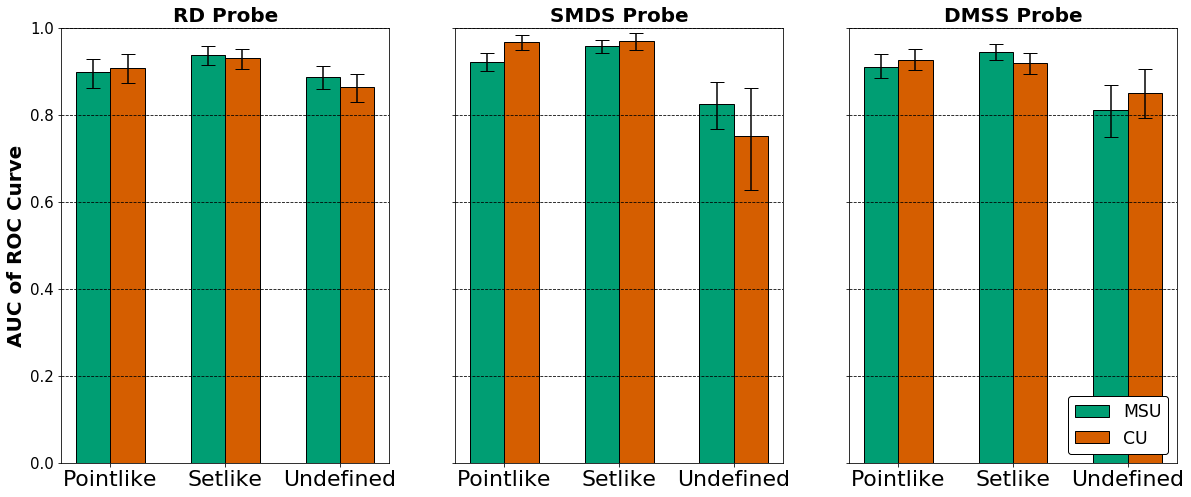

In [16]:
#Visualizing performance of each probe by plotting a bar plot displaying the mean of each code's AUC with 95% confidence intervals
#MSU first
fig,ax = plt.subplots(1,3,figsize=(20,8), sharey=True)
classes = ['P', 'S', 'U']
probe_list = ["RD","SMDS","DMSS"]
for i,probe in enumerate(probe_list):
    x_pos = np.arange(0,3,1)
    width = .3
    #Mean AUCs for each code
    y_means = np.array([MSU_P[probe].mean(), MSU_S[probe].mean(), MSU_U[probe].mean()])
    
    print(probe)
    print("MSU")
    print(y_means)
    #95% confidence intervals
    y_err_min = y_means - np.array([MSU_P[probe].quantile(.025) , MSU_S[probe].quantile(.025) , MSU_U[probe].quantile(.025)])
    y_err_max = np.array([MSU_P[probe].quantile(.975) , MSU_S[probe].quantile(.975) , MSU_U[probe].quantile(.975)]) - y_means
    
    print(y_means - y_err_min)
    print(y_means + y_err_max)
    y_err = [y_err_min , y_err_max]
    ax[i].set_ylim(0,1)
    MSU_rect = ax[i].bar(x_pos - width/2, y_means, yerr = y_err, width = width, edgecolor='black', color = "#009E73", capsize = 7)
    
    y_means = np.array([CU_P[probe].mean(), CU_S[probe].mean(), CU_U[probe].mean()])
    
    print("CU")
    print(y_means)
    #95% confidence intervals
    y_err_min = y_means - np.array([CU_P[probe].quantile(.025) , CU_S[probe].quantile(.025) , CU_U[probe].quantile(.025)])
    y_err_max = np.array([CU_P[probe].quantile(.975) , CU_S[probe].quantile(.975) , CU_U[probe].quantile(.975)]) - y_means
    
    print(y_means - y_err_min)
    print(y_means + y_err_max)
    
    y_err = [y_err_min , y_err_max]
    ax[i].set_ylim(0,1)
    CU_rect = ax[i].bar(x_pos + width/2, y_means, yerr = y_err, width = width, edgecolor='black', color = "#D55E00", capsize = 7)
    
    ax[i].tick_params(labelsize = 15, grid_color = "black", grid_linestyle = '--')
    ax[i].tick_params(labelsize = 22, axis = 'x')
    ax[i].set_title(f'{probe} Probe', fontsize = 20, fontweight = "bold")
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(['Pointlike', 'Setlike', 'Undefined'])
    
    if i == 0:
        ax[i].set_ylabel('AUC of ROC Curve', fontsize = 20, fontweight = "bold")
    elif i == 2:
        ax[i].legend((MSU_rect, CU_rect), ('MSU','CU'), loc = "lower right", fontsize = 'xx-large', framealpha = 1, edgecolor = "black")
        
    ax[i].grid(axis = 'y')
        
    


    
    
    
    
    
    
#plt.suptitle("Average AUCs of Each Model When Trained and Tested on Corresponding Populations")
plt.savefig("Average AUCs of Each Model When Trained and Tested on Corresponding Populations")

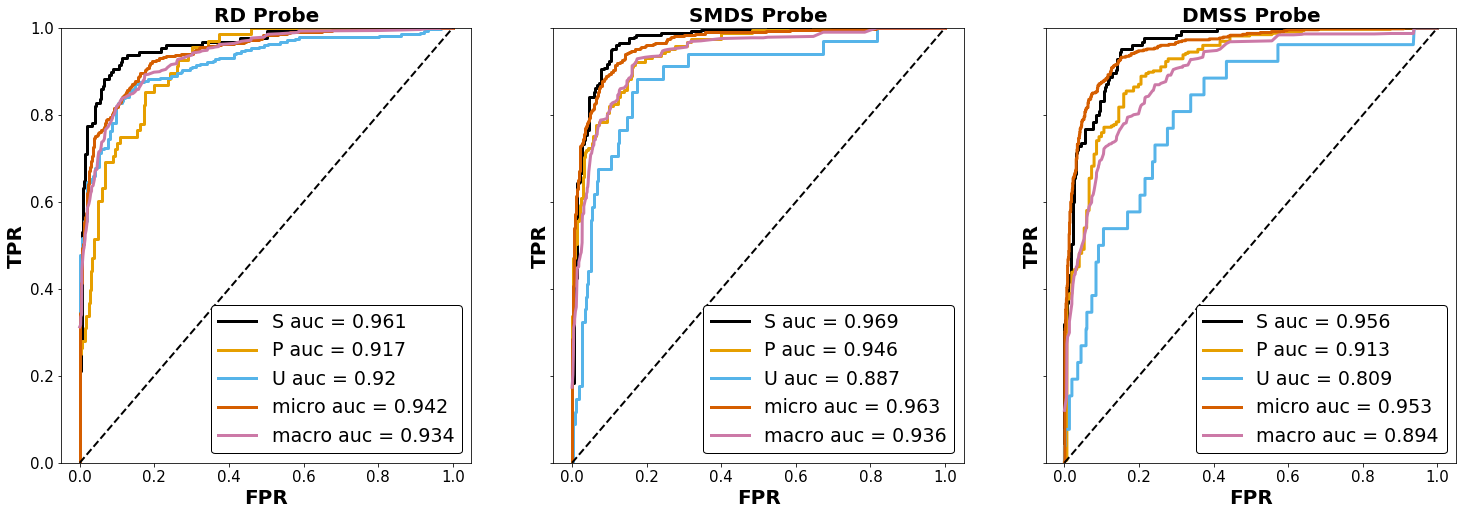

<Figure size 432x288 with 0 Axes>

In [17]:
#Plotting the ROC curve of the models with the highest micro AUC

#Finding Optimal

CU_optimal_idx = {}
MSU_optimal_idx = {}

for itr in range(iterations):
    for probe in probes:
        if max(CU_micros[probe]) == CU_micros[probe][itr]:
            CU_optimal_idx[probe] = itr
        
        if max(MSU_micros[probe]) == MSU_micros[probe][itr]:
            MSU_optimal_idx[probe] = itr
            
MSU_optimal_model = {}
CU_optimal_model = {}
            
for probe in probes:
    MSU_optimal_model[probe] = MSU_model_dict[MSU_optimal_idx[probe]][probe]
    CU_optimal_model[probe] = CU_model_dict[CU_optimal_idx[probe]][probe]

def ROC_OVR_plot(model_dict,title):
    fig,ax = plt.subplots(1,3,figsize=(25,8), sharey=True)
    for i,probe in enumerate(["RD","SMDS","DMSS"]):
        ax[i].set_ylim(0,1)
        ax[i].plot(model_dict[probe]["FPR"]['S'],model_dict[probe]["TPR"]['S'],label = 'S auc = {}'.format(round(model_dict[probe]['AUC']['S'],3)),linewidth = 3,color = (0,0,0))
        ax[i].plot(model_dict[probe]["FPR"]['P'],model_dict[probe]["TPR"]['P'],label = 'P auc = {}'.format(round(model_dict[probe]['AUC']['P'],3)),linewidth = 3, color = (230/255,159/255,0))
        ax[i].plot(model_dict[probe]["FPR"]['U'],model_dict[probe]["TPR"]['U'],label = 'U auc = {}'.format(round(model_dict[probe]['AUC']['U'],3)),linewidth = 3, color = (86/255,180/255,233/255))
        ax[i].plot(model_dict[probe]["FPR"]['micro'],model_dict[probe]["TPR"]['micro'],label = 'micro auc = {}'.format(round(model_dict[probe]['AUC']['micro'],3)),linewidth = 3, color = (213/255, 94/255, 0))
        ax[i].plot(model_dict[probe]["FPR"]['macro'],model_dict[probe]["TPR"]['macro'],label = 'macro auc = {}'.format(round(model_dict[probe]['AUC']['macro'],3)),linewidth = 3, color = (204/255, 121/255, 167/255))
        ax[i].plot([0,1],[0,1],lw=2,linestyle = "--", color = "black")
        ax[i].set_ylabel('TPR', fontsize = 20, fontweight = 'bold')
        ax[i].set_xlabel('FPR', fontsize = 20, fontweight = 'bold')
        ax[i].set_title(f'{probe} Probe', fontsize = 20, fontweight = 'bold')
        ax[i].legend(fontsize = 19, framealpha = 1, edgecolor = "black")
        ax[i].tick_params(labelsize = 15)
    #plt.suptitle(title)
    #plt.savefig(filename, bbox_inches='tight')    
    plt.show()        

#MSU

ROC_OVR_plot(MSU_optimal_model,"ROC Curve of Optimal MSU Model When Tested On Corresponding Population")
plt.savefig("ROC Curve of Optimal MSU Model When Tested On Corresponding Population")



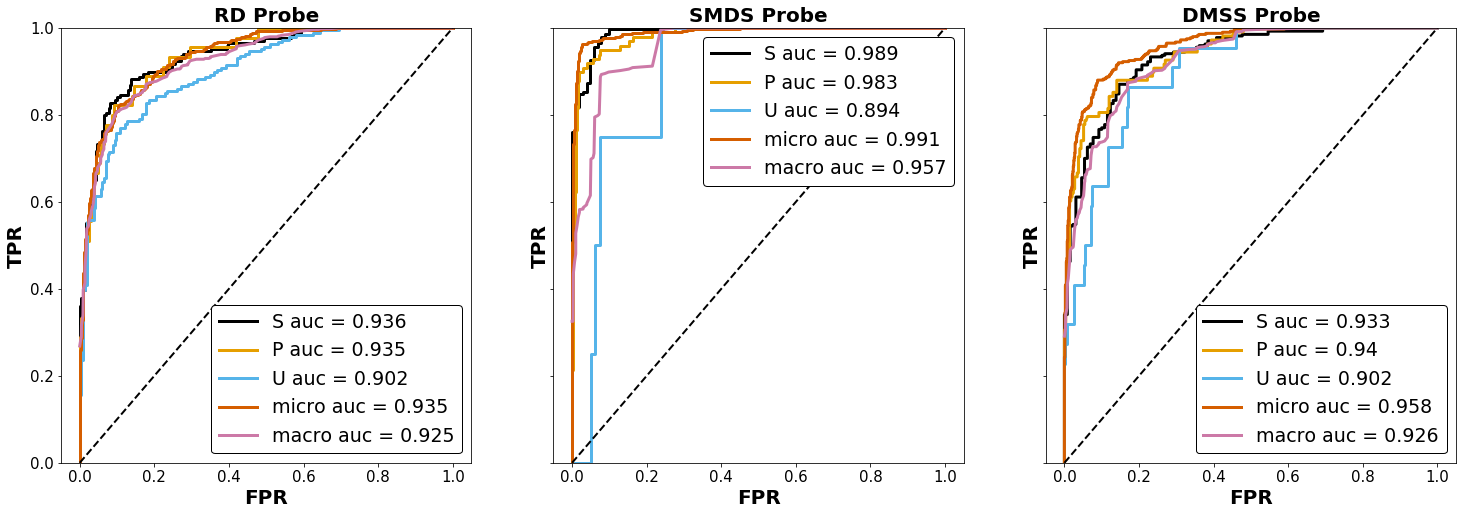

<Figure size 432x288 with 0 Axes>

In [18]:
ROC_OVR_plot(CU_optimal_model,"ROC Curve of Optimal CU Model When Tested On Corresponding Population")
plt.savefig("ROC Curve of Optimal CU Model When Tested On Corresponding Population")

# Interrater Reliability Between Human and Machine Classifiers

Shown below is the average Cohen's Kappa between the human researcher and the OVR logistic regression classifier on each probe. The Cohen's Kappa is calculated on a testing set composed of 20% of the student data from the same population that the OVR classifier was trained on. These values, showing moderate-substantial agreement(Kappa = .41-.80), encapsulate the inter-rater reliability expected when testing across populations in the best case scenario where the new population is exactly like the training population.


MSU
[0.59111968 0.66896119 0.58934867]
[0.53758782 0.61325348 0.52574344]
[0.64928603 0.72091123 0.65509354]
CU
[0.57843678 0.79228963 0.57308679]
[0.50614762 0.7303446  0.5003885 ]
[0.64513564 0.84696565 0.6428871 ]


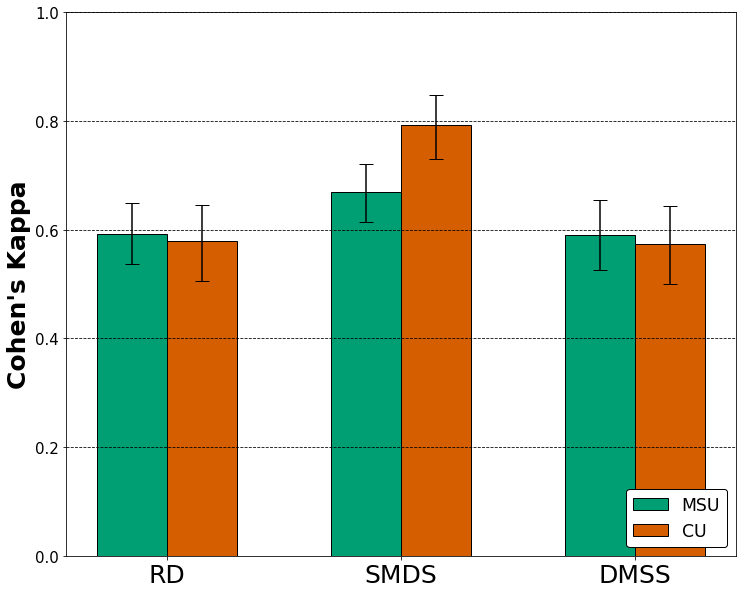

In [19]:
#Visualizing performance of each probe by plotting a bar plot displaying the mean of each probe's Cohen's Kappa with 95% confidence intervals
#MSU first
fig,ax = plt.subplots(figsize=(12,10), sharey=True)
classes = ['P', 'S', 'U']
x_pos = np.arange(0,3,1)
width = .3
#Mean AUCs for each code
y_means = np.array([MSU_kappas["RD"].mean(), MSU_kappas["SMDS"].mean(), MSU_kappas["DMSS"].mean()])

print("MSU")
print(y_means)

#95% confidence intervals
y_err_min = y_means - np.array([MSU_kappas["RD"].quantile(.025) , MSU_kappas["SMDS"].quantile(.025) , MSU_kappas["DMSS"].quantile(.025)])
y_err_max = np.array([MSU_kappas["RD"].quantile(.975) , MSU_kappas["SMDS"].quantile(.975) , MSU_kappas["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)

y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
MSU_rect = ax.bar(x_pos - width/2, y_means, yerr = y_err, width = width, color = "#009E73", edgecolor = "black", capsize = 7)

y_means = np.array([CU_kappas["RD"].mean(), CU_kappas["SMDS"].mean(), CU_kappas["DMSS"].mean()])

print("CU")
print(y_means)

#95% confidence intervals
y_err_min = y_means - np.array([CU_kappas["RD"].quantile(.025) , CU_kappas["SMDS"].quantile(.025) , CU_kappas["DMSS"].quantile(.025)])
y_err_max = np.array([CU_kappas["RD"].quantile(.975) , CU_kappas["SMDS"].quantile(.975) , CU_kappas["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)

y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
CU_rect = ax.bar(x_pos + width/2, y_means, yerr = y_err, width = width, color = "#D55E00", edgecolor = "black", capsize = 7)

ax.set_xticks(x_pos)
ax.set_xticklabels(['RD', 'SMDS', 'DMSS'])

ax.tick_params(labelsize = 15, grid_color = "black", grid_linestyle = '--')
ax.tick_params(labelsize = 25, axis = 'x')
ax.set_xticks(x_pos)
ax.set_xticklabels(['RD', 'SMDS', 'DMSS'])
ax.set_ylabel("Cohen's Kappa", fontsize = 25, fontweight = "bold")
ax.legend((MSU_rect, CU_rect), ('MSU','CU'), loc = "lower right", fontsize = 'xx-large', framealpha = 1, edgecolor = "black")
ax.grid(axis = 'y')
    
    
#ax.set_title("Average Cohen's Kappa with Human Researcher For Each Model, Trained and Tested on Corresponding Populations")
plt.savefig("Average Cohen's Kappa with Human Researcher For Each Model, Trained and Tested on Corresponding Populations")

# Evaluating Robustness

In the following sections the robustness of OVR logistic regression classifier on PMQ data will be evaluated using a slew of different metrics.

### Highest Magnitude Weights

A good indication that the OVR logistic regression models are robust under population differences is if training on the two populations result in similar model parameters. One way to check if the logistic regression models are similar is to investigate the words in each model that hold the most importance in determining if a response is classified as point-like, set-like, or undefined. These are the words with the highest magnitude weights assigned to them through training. Both models using the same or similar words to classify a response as point-like or set-like indicates that the two models are similar. Since a logistic regression model is made for each classification in the OVR framework,  the highest magnitude weighted words from the models responsible for classifying point-like and set-like responses are compared.

### Measuring Performance and Inter-rater reliability Across Populations

To further measure the robustness, each model created from the 500 iterations will be tested on the opposing population's testing sets. From this testing the average AUC of the ROC curves from the models trained on the opposite population will be computed and compared with the average AUC of the models trained on the matching population of the testing sets. This result will be displayed on a bar graph where the height of each bar is the mean AUC value of the 500 models with an error bar representing the 95% confidence interval. Similar AUC values would suggest that models trained on the opposing population perform just as well as models trained on the matching population. 

A similar procedure will be done to measure inter-rater reliability. For each population, the 500 OVR models created are tested on the 500 testing sets of the other population and the Cohen's Kappa is computed relative to the human researchers of the other population. Additionally, to get a measure of the agreement between the models produced from both populations, the Cohen's Kappa is also computed relative to the models trained on the other population.


# Highest Magnitude Weights

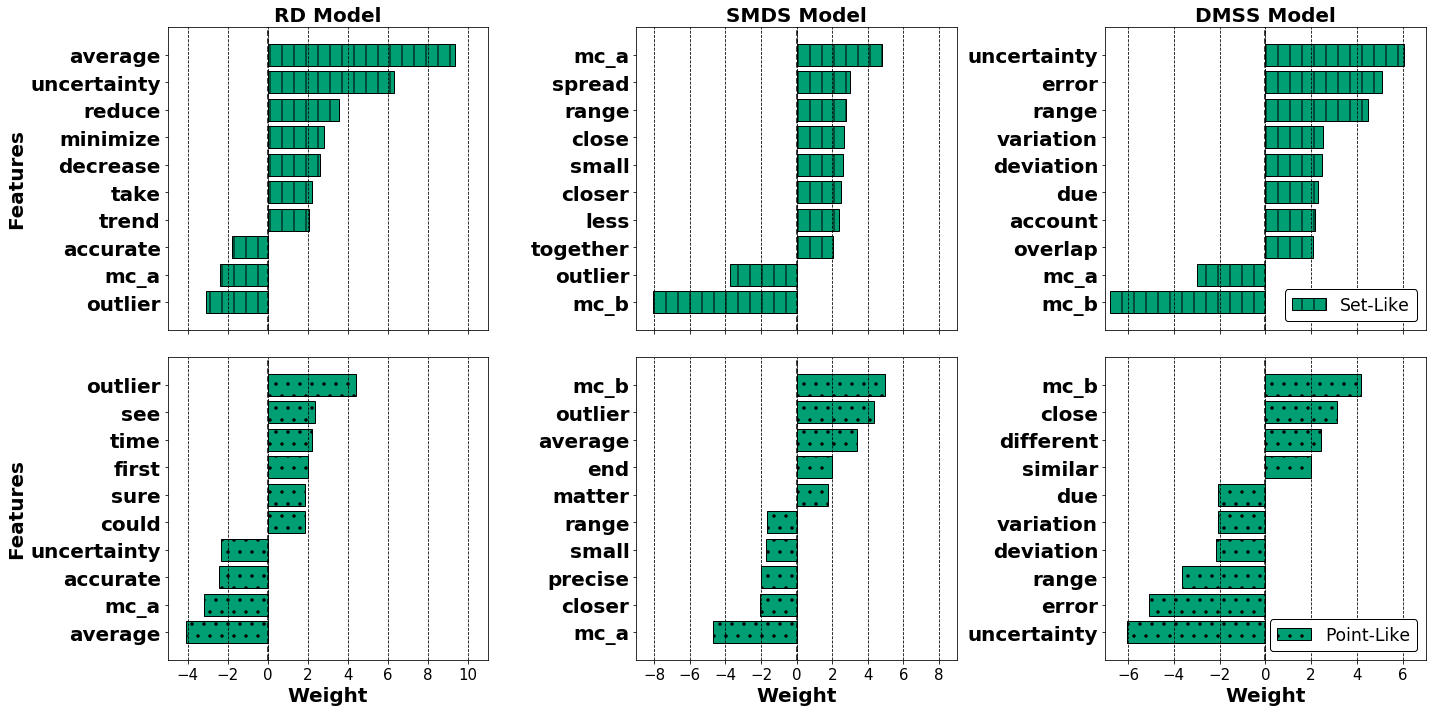

<Figure size 432x288 with 0 Axes>

In [20]:
#Find Highest Magnitude Weights of the model with the highest micro AUC of each population
#MSU
highest_features_MSU = {}

for probe in ["RD","SMDS","DMSS"]:
    highest_features_MSU[probe] = {}

for c in range(0,2):
    for probe in ["RD","SMDS","DMSS"]:
        coeff = (MSU_optimal_model[probe]["Model"].coef_[c]).copy()
        vocab = MSU_optimal_model[probe]["vocab"]
        max_feature = coeff[0]
        highest_feature_MSU = []
        for i in range(10):
            for j in range(len(coeff)):
                if abs(coeff[j]) > abs(max_feature):
                    max_feature = coeff[j]
                    max_index = j

            coeff[max_index] = 0 
            for key in vocab:
                if vocab[key] == max_index:
                    highest_feature_MSU.append((key,max_feature,max_index))
            max_feature = 0
        
        highest_features_MSU[probe][c] = highest_feature_MSU
        
#CU
highest_features_CU = {}

for probe in ["RD","SMDS","DMSS"]:
    highest_features_CU[probe] = {}

for c in range(0,2):
    for probe in ["RD","SMDS","DMSS"]:
        coeff = (CU_optimal_model[probe]["Model"].coef_[c]).copy()
        vocab = CU_optimal_model[probe]["vocab"]
        max_feature = coeff[0]
        highest_feature_CU = []
        for i in range(10):
            for j in range(len(coeff)):
                if abs(coeff[j]) > abs(max_feature):
                    max_feature = coeff[j]
                    max_index = j

            coeff[max_index] = 0 
            for key in vocab:
                if vocab[key] == max_index:
                    highest_feature_CU.append((key,max_feature,max_index))
            max_feature = 0
        
        highest_features_CU[probe][c] = highest_feature_CU
        

# MSU first
highest_weighted_features_barplot(highest_features_MSU, "Highest Magnitude Words for the Optimal MSU Trained OVR Model", color = "#009E73", college = "MSU")
plt.savefig("Highest Magnitude Words for the Optimal MSU Trained OVR Model")

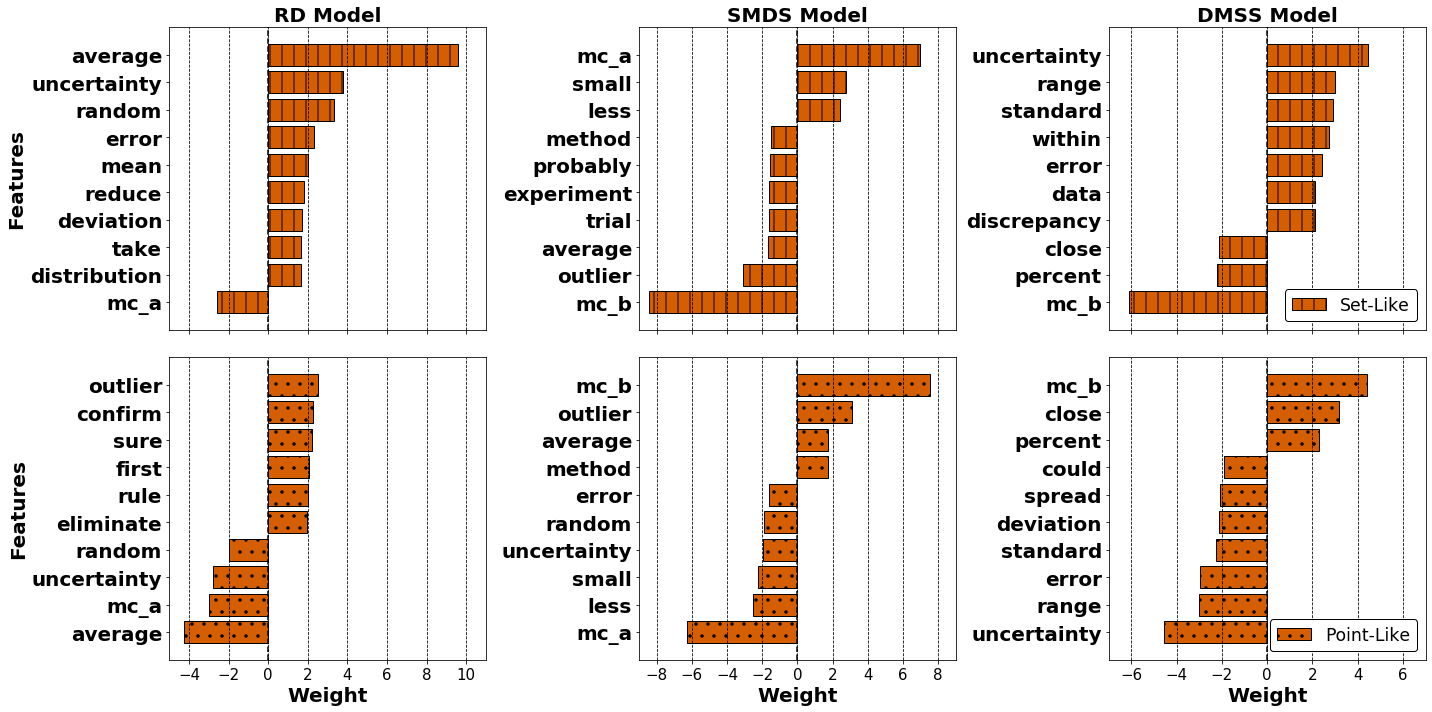

<Figure size 432x288 with 0 Axes>

In [21]:
highest_weighted_features_barplot(highest_features_CU, "Highest Magnitude Words for the Optimal CU Trained OVR Model")
plt.savefig("Highest Magnitude Words for the Optimal CU Trained OVR Model")

# Measuring Performance and Inter-rater reliability Across Populations

In [22]:
# Testing the 500 models produced from each population on the other population and gathering performance/inter-rater reliability metrics

#Dictionaries holding the results of testing MSU models testing on the CU population(MSU_CU) and vice versa(CU_MSU)
MSU_CU_metrics = {}
CU_MSU_metrics = {}

iterations = 500
for itr in range(iterations):
    #Results from each iteration
    MSU_CU_metrics[itr] = {}
    CU_MSU_metrics[itr] = {}
    
    for probe in probes:
        #Results for each probe
        MSU_CU_metrics[itr][probe] = {}
        CU_MSU_metrics[itr][probe] = {}
        
        #Measure TPR, FPR, and AUC
        MSU_CU_metrics[itr][probe]["TPR"] = {}
        MSU_CU_metrics[itr][probe]["FPR"] = {}
        MSU_CU_metrics[itr][probe]["AUC"] = {}

        CU_MSU_metrics[itr][probe]["TPR"] = {}
        CU_MSU_metrics[itr][probe]["FPR"] = {}
        CU_MSU_metrics[itr][probe]["AUC"] = {}
        
        #Converting each testing set to the TFIDF values of the other college's vocabulary.
        CU_test_vector = MSU_model_dict[itr][probe]["vectorizer"].transform(CU_model_dict[itr][probe]["test_text"])
        MSU_test_vector = CU_model_dict[itr][probe]["vectorizer"].transform(MSU_model_dict[itr][probe]["test_text"])
        
        #Using the model from each college to predict the other's testing set
        MSU_CU_metrics[itr][probe]["Test_pred"] = label_binarize(MSU_model_dict[itr][probe]["Model"].predict(CU_test_vector) , classes = ['P','S','U'])
        CU_MSU_metrics[itr][probe]["Test_pred"] = label_binarize(CU_model_dict[itr][probe]["Model"].predict(MSU_test_vector) , classes = ['P','S','U'])

        #Computing ROC metrics for MSU tested on CU data and vice versa

        MSU_CU_metrics[itr]["test_scores"] = MSU_model_dict[itr][probe]["Model"].predict_proba(CU_test_vector)
        CU_MSU_metrics[itr]["test_scores"] = CU_model_dict[itr][probe]["Model"].predict_proba(MSU_test_vector)

        for i,code in [(0,'P'), (1,'S'), (2,'U')]:
            MSU_CU_metrics[itr][probe]["FPR"][code] , MSU_CU_metrics[itr][probe]["TPR"][code], _ = roc_curve(CU_model_dict[itr][probe]["test_labels"][:,i], MSU_CU_metrics[itr]["test_scores"][:, i])
            CU_MSU_metrics[itr][probe]["FPR"][code] , CU_MSU_metrics[itr][probe]["TPR"][code], _ = roc_curve(MSU_model_dict[itr][probe]["test_labels"][:,i], CU_MSU_metrics[itr]["test_scores"][:, i])

            MSU_CU_metrics[itr][probe]["AUC"][code] = auc(MSU_CU_metrics[itr][probe]["FPR"][code], MSU_CU_metrics[itr][probe]["TPR"][code])
            CU_MSU_metrics[itr][probe]["AUC"][code] = auc(CU_MSU_metrics[itr][probe]["FPR"][code], CU_MSU_metrics[itr][probe]["TPR"][code])
        
        #Computing the micro FPR, TPR, and auc by raveling the labels and decision probabilities together
        MSU_CU_metrics[itr][probe]["FPR"]["micro"], MSU_CU_metrics[itr][probe]["TPR"]["micro"], _ = roc_curve(CU_model_dict[itr][probe]["test_labels"].ravel(), MSU_CU_metrics[itr]["test_scores"].ravel())
        MSU_CU_metrics[itr][probe]["AUC"]["micro"] = auc(MSU_CU_metrics[itr][probe]["FPR"]["micro"], MSU_CU_metrics[itr][probe]["TPR"]["micro"])

        CU_MSU_metrics[itr][probe]["FPR"]["micro"], CU_MSU_metrics[itr][probe]["TPR"]["micro"], _ = roc_curve(MSU_model_dict[itr][probe]["test_labels"].ravel(), CU_MSU_metrics[itr]["test_scores"].ravel())
        CU_MSU_metrics[itr][probe]["AUC"]["micro"] = auc(CU_MSU_metrics[itr][probe]["FPR"]["micro"], CU_MSU_metrics[itr][probe]["TPR"]["micro"])

        #Computing the macro auc 
        #First concatenate the entire FPR space across each classification
        MSU_CU_combined_fpr = np.unique(np.concatenate([MSU_CU_metrics[itr][probe]["FPR"][code] for code in ['P','S','U']]))
        CU_MSU_combined_fpr = np.unique(np.concatenate([CU_MSU_metrics[itr][probe]["FPR"][code] for code in ['P','S','U']]))

        #Then linearly interpolate the TPRs for each classification to the new FPR space
        MSU_CU_mean_tpr = np.zeros_like(MSU_CU_combined_fpr)
        CU_MSU_mean_tpr = np.zeros_like(CU_MSU_combined_fpr)

        for code in ['P','S','U']:
            MSU_CU_mean_tpr += np.interp(MSU_CU_combined_fpr, MSU_CU_metrics[itr][probe]["FPR"][code], MSU_CU_metrics[itr][probe]["TPR"][code])
            CU_MSU_mean_tpr += np.interp(CU_MSU_combined_fpr, CU_MSU_metrics[itr][probe]["FPR"][code], CU_MSU_metrics[itr][probe]["TPR"][code])

        #Finally average it and compute macro AUC
        MSU_CU_mean_tpr /= n_classes
        CU_MSU_mean_tpr /= n_classes

        MSU_CU_metrics[itr][probe]["FPR"]["macro"] = MSU_CU_combined_fpr
        CU_MSU_metrics[itr][probe]["FPR"]["macro"] = CU_MSU_combined_fpr

        MSU_CU_metrics[itr][probe]["TPR"]["macro"] = MSU_CU_mean_tpr
        CU_MSU_metrics[itr][probe]["TPR"]["macro"] = CU_MSU_mean_tpr

        MSU_CU_metrics[itr][probe]["AUC"]["macro"] = auc(MSU_CU_metrics[itr][probe]["FPR"]["macro"],MSU_CU_metrics[itr][probe]["TPR"]["macro"])
        CU_MSU_metrics[itr][probe]["AUC"]["macro"] = auc(CU_MSU_metrics[itr][probe]["FPR"]["macro"],CU_MSU_metrics[itr][probe]["TPR"]["macro"])

        #Compute accuracy and cohen's kappa for each probe

        #First compute the confusion matrix between the two models, M[i,j] is how many i classifications are predicted to be j. 0:P, 1:S, 2:U
        #test_results_binary = label_binarize(OVR_models[probe]["test_results"], classes = ['P','S','U'])
        
        MSU_CU_conf_matr = confusion_matrix(MSU_model_dict[itr][probe]["Model"].predict(CU_test_vector),
                                     CU_model_dict[itr][probe]["test_results"],
                                     labels = ['P','S','U'])

        CU_MSU_conf_matr = confusion_matrix(CU_model_dict[itr][probe]["Model"].predict(MSU_test_vector),
                                     MSU_model_dict[itr][probe]["test_results"],
                                     labels = ['P','S','U'])

        #To compute Cohen's Kappa between the models and human researchers on either population, additional confusion matricies between the 
        #model trained on a different population and the results from the human researcher
        #MSU population
        
        MSU_H_conf_matr = confusion_matrix(CU_model_dict[itr][probe]["Model"].predict(MSU_test_vector),
                                     MSU_model_dict[itr][probe]["test_labels_nb"],
                                     labels = ['P','S','U'])

        #CU population
        CU_H_conf_matr = confusion_matrix(MSU_model_dict[itr][probe]["Model"].predict(CU_test_vector),
                                     CU_model_dict[itr][probe]["test_labels_nb"],
                                     labels = ['P','S','U'])
        


        #Accuracy is just the trace divided by the lump sum of each entry
        N_MC = np.sum(MSU_CU_conf_matr.ravel())
        N_CM = np.sum(CU_MSU_conf_matr.ravel())
        N_MH = N_CM
        N_CH = N_MC
        
        TP_MC = np.trace(MSU_CU_conf_matr)
        TP_CM = np.trace(CU_MSU_conf_matr)
        TP_MH = np.trace(MSU_H_conf_matr)
        TP_CH = np.trace(CU_H_conf_matr)
        
        MSU_CU_metrics[itr][probe]["Acc_MM"] = TP_MC / N_MC
        CU_MSU_metrics[itr][probe]["Acc_MM"] = TP_CM / N_CM
        MSU_CU_metrics[itr][probe]["Acc_HM"] = TP_CH / N_CH
        CU_MSU_metrics[itr][probe]["Acc_HM"] = TP_MH / N_MH

        #Calculating the estimated chance agreement
        C_MC = 0   #MSU tested on CU Cohen's Kappa between the two models
        C_CM = 0   #CU tested on MSU Cohen's Kappa between the two models
        C_CH = 0   #Cohen's Kappa between the MSU trained model and human researcher on CU testing set
        C_MH = 0   #Cohen's Kappa between the CU trained model and human researcher on MSU testing set
        
        for i in range(len(conf_matr)):
            N_MC_i = MSU_CU_conf_matr[i,:].sum()  #Number of classifications
            N_CM_i = CU_MSU_conf_matr[i,:].sum()
            N_MH_i = MSU_H_conf_matr[i,:].sum()
            N_CH_i = CU_H_conf_matr[i,:].sum()
            
            P_MC_i = MSU_CU_conf_matr[:,i].sum()  #Number of predicted classifications
            P_CM_i = CU_MSU_conf_matr[:,i].sum()
            P_MH_i = MSU_H_conf_matr[:,i].sum()  
            P_CH_i = CU_H_conf_matr[:,i].sum()
            
            C_MC += N_MC_i/N_MC * P_MC_i/N_MC          #ith term of chance agreement
            C_CM += N_CM_i/N_CM * P_CM_i/N_CM
            C_MH += N_MH_i/N_MH * P_MH_i/N_MH          
            C_CH += N_CH_i/N_CH * P_CH_i/N_CH
        
        K_MC = ( (TP_MC / N_MC) - C_MC ) / ( 1 - C_MC )
        K_CM = ( (TP_CM / N_CM) - C_CM ) / ( 1 - C_CM )
        K_MH = ( (TP_MH / N_MH) - C_MH ) / ( 1 - C_MH )
        K_CH = ( (TP_CH / N_CH) - C_CH ) / ( 1 - C_CH )
        
        #MM stands for Machine-Machine, HM stands for Human-Machine.
        MSU_CU_metrics[itr][probe]["Kappa_MM"] = K_MC
        CU_MSU_metrics[itr][probe]["Kappa_MM"] = K_CM
        MSU_CU_metrics[itr][probe]["Kappa_HM"] = K_CH
        CU_MSU_metrics[itr][probe]["Kappa_HM"] = K_MH
    
    
    
#Collecting the cohen kappas and micro, P, S, and U aucs for each probe and converting into pandas series objects for easy computation of the mean and 95% confidence intervals
MSU_CU_kappas = {}
MSU_CU_kappas_H = {}
MSU_CU_micros = {}
MSU_CU_P = {}
MSU_CU_S = {}
MSU_CU_U = {}

CU_MSU_kappas = {}
CU_MSU_kappas_H = {}
CU_MSU_micros = {}
CU_MSU_P = {}
CU_MSU_S = {}
CU_MSU_U = {}

for probe in probes:
    MC_kappas = []
    MC_kappas_H = []
    MC_micros = []
    MC_P = []
    MC_S = []
    MC_U = []
    
    CM_kappas = []
    CM_kappas_H = []
    CM_micros = []
    CM_P = []
    CM_S = []
    CM_U = []
    
    for itr in range(iterations):
        MC_kappas.append(MSU_CU_metrics[itr][probe]["Kappa_MM"])
        MC_kappas_H.append(MSU_CU_metrics[itr][probe]["Kappa_HM"])
        MC_micros.append(MSU_CU_metrics[itr][probe]["AUC"]["micro"])
        MC_P.append(MSU_CU_metrics[itr][probe]["AUC"]["P"])
        MC_S.append(MSU_CU_metrics[itr][probe]["AUC"]["S"])
        MC_U.append(MSU_CU_metrics[itr][probe]["AUC"]["U"])
        
        CM_kappas.append(CU_MSU_metrics[itr][probe]["Kappa_MM"])
        CM_kappas_H.append(CU_MSU_metrics[itr][probe]["Kappa_HM"])
        CM_micros.append(CU_MSU_metrics[itr][probe]["AUC"]["micro"])
        CM_P.append(CU_MSU_metrics[itr][probe]["AUC"]["P"])
        CM_S.append(CU_MSU_metrics[itr][probe]["AUC"]["S"])
        CM_U.append(CU_MSU_metrics[itr][probe]["AUC"]["U"])
        
    
    MSU_CU_kappas[probe] = pd.Series(MC_kappas)
    MSU_CU_kappas_H[probe] = pd.Series(MC_kappas_H)
    MSU_CU_micros[probe] = pd.Series(MC_micros)
    MSU_CU_P[probe] = pd.Series(MC_P)
    MSU_CU_S[probe] = pd.Series(MC_S)
    MSU_CU_U[probe] = pd.Series(MC_U)
    
    CU_MSU_kappas[probe] = pd.Series(CM_kappas)
    CU_MSU_kappas_H[probe] = pd.Series(CM_kappas_H)
    CU_MSU_micros[probe] = pd.Series(CM_micros)
    CU_MSU_P[probe] = pd.Series(CM_P)
    CU_MSU_S[probe] = pd.Series(CM_S)
    CU_MSU_U[probe] = pd.Series(CM_U)

# Performance

Displayed Below are the Average AUC of both models when tested on each population. These figures illustrate the performance loss expected when testing OVR logistic regression models on PMQ data retrieved from different populations.

RD
MSU
[0.87504242 0.90359408 0.83546286]
[0.83684375 0.87668696 0.79609406]
[0.91573719 0.93233126 0.87124185]
CU
[0.90849165 0.92999192 0.86368986]
[0.87263997 0.90498982 0.82940897]
[0.93914177 0.95176203 0.89409023]
SMDS
MSU
[0.95997461 0.95685869 0.67519331]
[0.93850753 0.93285617 0.54025807]
[0.97874003 0.97795888 0.79840774]
CU
[0.96761031 0.97048787 0.75067868]
[0.94809394 0.95015935 0.62805769]
[0.98367452 0.98764436 0.86173926]
DMSS
MSU
[0.91065694 0.85971936 0.6129797 ]
[0.87692366 0.826831   0.51974168]
[0.93859557 0.89426083 0.7026368 ]
CU
[0.92719781 0.91932812 0.85038961]
[0.90282392 0.89321468 0.79180492]
[0.95169143 0.94189663 0.90633806]


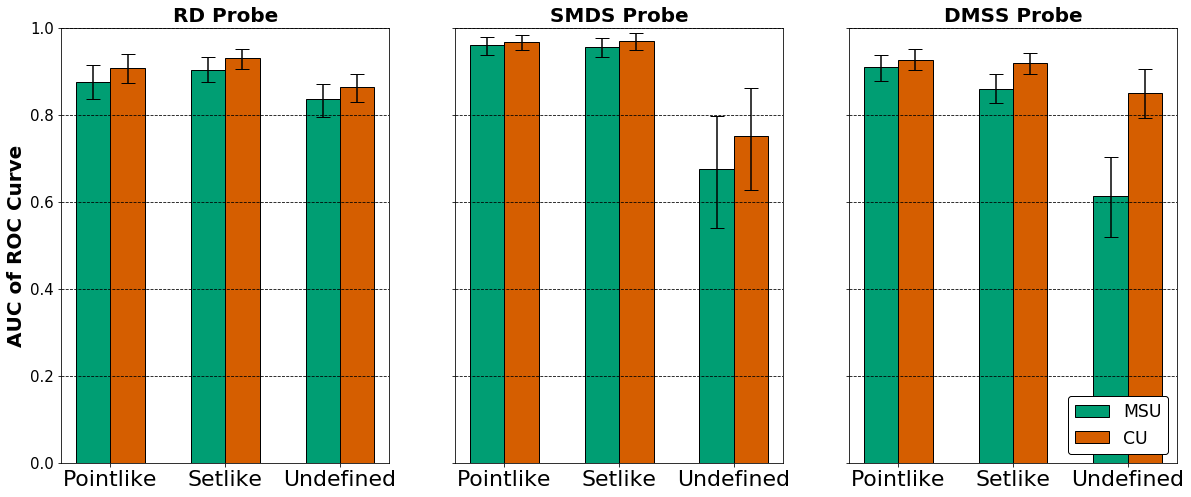

In [23]:
#Visualizing performance of each probe by plotting a bar plot displaying the mean of each code's AUC with 95% confidence intervals
# First the CU population
fig,ax = plt.subplots(1,3,figsize=(20,8), sharey=True)
classes = ['P', 'S', 'U']
probe_list = ["RD","SMDS","DMSS"]
for i,probe in enumerate(probe_list):
    x_pos = np.arange(0,3,1)
    width = .3
    #Mean AUCs for each code
    
    print(probe)
    print("MSU")
    y_means = np.array([MSU_CU_P[probe].mean(), MSU_CU_S[probe].mean(), MSU_CU_U[probe].dropna().mean()])
    
    print(y_means)
    #95% confidence intervals
    y_err_min = y_means - np.array([MSU_CU_P[probe].quantile(.025) , MSU_CU_S[probe].quantile(.025) , MSU_CU_U[probe].quantile(.025)])
    y_err_max = np.array([MSU_CU_P[probe].quantile(.975) , MSU_CU_S[probe].quantile(.975) , MSU_CU_U[probe].quantile(.975)]) - y_means
    
    print(y_means - y_err_min)
    print(y_means + y_err_max)
    
    y_err = [y_err_min , y_err_max]
    MSU_rect = ax[i].bar(x_pos - width/2, y_means, yerr = y_err, width = width, color = "#009E73", edgecolor='black', capsize = 7)
    
    print("CU")
    y_means = np.array([CU_P[probe].mean(), CU_S[probe].mean(), CU_U[probe].mean()])
    
    print(y_means)
    #95% confidence intervals
    y_err_min = y_means - np.array([CU_P[probe].quantile(.025) , CU_S[probe].quantile(.025) , CU_U[probe].quantile(.025)])
    y_err_max = np.array([CU_P[probe].quantile(.975) , CU_S[probe].quantile(.975) , CU_U[probe].quantile(.975)]) - y_means
    
    print(y_means - y_err_min)
    print(y_means + y_err_max)
    
    y_err = [y_err_min , y_err_max]
    ax[i].set_ylim(0,1)
    CU_rect = ax[i].bar(x_pos + width/2, y_means, yerr = y_err, width = width, color = "#D55E00", edgecolor='black', capsize = 7)
    
    ax[i].tick_params(labelsize = 15, grid_color = "black", grid_linestyle = '--')
    ax[i].tick_params(axis = 'x', labelsize = 22)
    ax[i].set_title(f'{probe} Probe', fontsize = 20, fontweight = "bold")
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(['Pointlike', 'Setlike', 'Undefined'])
    
    if i == 0:
        ax[i].set_ylabel('AUC of ROC Curve', fontsize = 20, fontweight = "bold")
    elif i == 2:
        ax[i].legend((MSU_rect, CU_rect), ('MSU','CU'), loc = "lower right", fontsize = 'xx-large', framealpha = 1, edgecolor = "black")
        
    ax[i].grid(axis = 'y')
    
    
plt.savefig("Average AUCs For Each Model, Tested on CU Population")

RD
MSU
[0.86837023 0.91986963 0.85287811]
[0.83010937 0.89609246 0.82311681]
[0.90541804 0.94305674 0.88000013]
CU
[0.8981482  0.9371542  0.88762953]
[0.86236873 0.91524159 0.85964306]
[0.92829207 0.95827582 0.91314985]
SMDS
MSU
[0.90457764 0.95185234 0.67068437]
[0.88042547 0.93343388 0.60337488]
[0.92701807 0.96767659 0.74165271]
CU
[0.92158216 0.95802124 0.82516381]
[0.90007174 0.94220733 0.76723827]
[0.94175395 0.97225853 0.87672664]
DMSS
MSU
[0.8747567  0.89485632 0.61241495]
[0.84254777 0.8668345  0.5217845 ]
[0.90484489 0.91867812 0.70305341]
CU
[0.91062037 0.94570995 0.81238743]
[0.88589174 0.92714545 0.75016437]
[0.94017079 0.96375108 0.86904954]


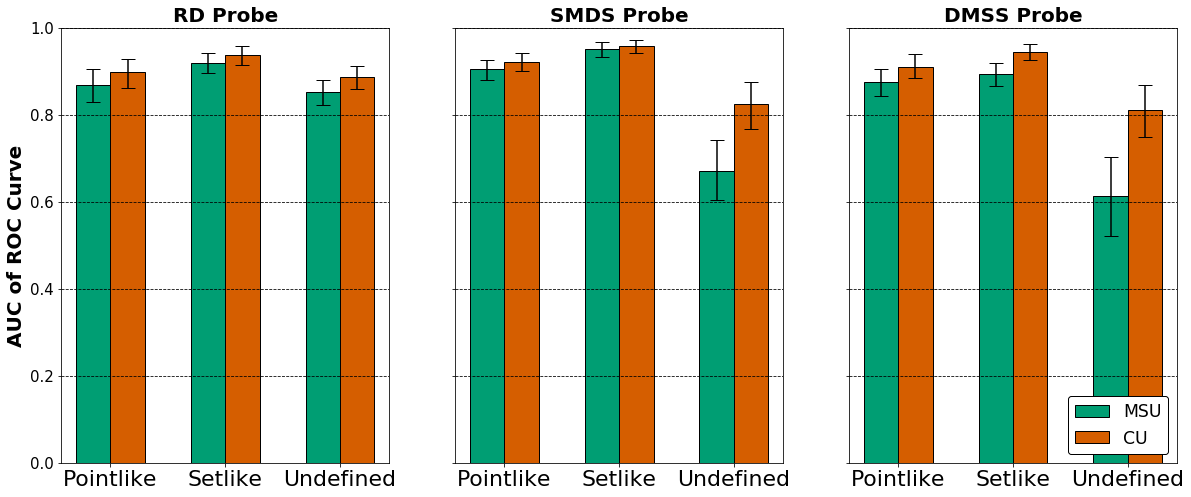

In [24]:
# Now the MSU population
fig,ax = plt.subplots(1,3,figsize=(20,8), sharey=True)
classes = ['P', 'S', 'U']
probe_list = ["RD","SMDS","DMSS"]
for i,probe in enumerate(probe_list):
    x_pos = np.arange(0,3,1)
    width = .3
    #Mean AUCs for each code
    
    print(probe)
    print("MSU")
    
    y_means = np.array([CU_MSU_P[probe].mean(), CU_MSU_S[probe].mean(), CU_MSU_U[probe].dropna().mean()])
    
    print(y_means)
    #95% confidence intervals
    y_err_min = y_means - np.array([CU_MSU_P[probe].quantile(.025) , CU_MSU_S[probe].quantile(.025) , CU_MSU_U[probe].quantile(.025)])
    y_err_max = np.array([CU_MSU_P[probe].quantile(.975) , CU_MSU_S[probe].quantile(.975) , CU_MSU_U[probe].quantile(.975)]) - y_means
    
    print(y_means - y_err_min)
    print(y_means + y_err_max)
    
    y_err = [y_err_min , y_err_max]
    ax[i].set_ylim(0,1)
    MSU_rect = ax[i].bar(x_pos - width/2, y_means, yerr = y_err, width = width, color = "#009E73", edgecolor='black', capsize = 7)
    ax[i].set_title(f'{probe} Probe')
    
    print("CU")
    y_means = np.array([MSU_P[probe].mean(), MSU_S[probe].mean(), MSU_U[probe].mean()])
    
    print(y_means)
    #95% confidence intervals
    y_err_min = y_means - np.array([MSU_P[probe].quantile(.025) , MSU_S[probe].quantile(.025) , MSU_U[probe].quantile(.025)])
    y_err_max = np.array([MSU_P[probe].quantile(.975) , MSU_S[probe].quantile(.975) , MSU_U[probe].quantile(.975)]) - y_means
    
    print(y_means - y_err_min)
    print(y_means + y_err_max)
    
    y_err = [y_err_min , y_err_max]
    ax[i].set_ylim(0,1)
    CU_rect = ax[i].bar(x_pos + width/2, y_means, yerr = y_err, width = width, color = "#D55E00", edgecolor='black', capsize = 7)
    
    ax[i].tick_params(labelsize = 15, grid_color = "black", grid_linestyle = '--')
    ax[i].tick_params(axis = 'x', labelsize = 22)
    ax[i].set_title(f'{probe} Probe', fontsize = 20, fontweight = "bold")
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(['Pointlike', 'Setlike', 'Undefined'])
    
    if i == 0:
        ax[i].set_ylabel('AUC of ROC Curve', fontsize = 20, fontweight = "bold")
    elif i == 2:
        ax[i].legend((MSU_rect, CU_rect), ('MSU','CU'), loc = "lower right", fontsize = 'xx-large', framealpha = 1, edgecolor = "black")
        
    ax[i].grid(axis = 'y')
    
    
plt.savefig("Average AUCs For Each Model, Tested on MSU Population")

# Inter-rater reliability, Machine - Machine

Shown below is the Cohen's Kappa between the models on each population. This figure illustrates the expected reliability between a model and the optimal model when testing on new populations.

MSU population
[0.72519754 0.95245532 0.4426298 ]
[0.66612472 0.91943311 0.37524544]
[0.77758257 0.9861988  0.50979298]
CU population
[0.73614519 0.92606369 0.44764867]
[0.67179257 0.89083495 0.38076482]
[0.79490894 0.95336787 0.51483789]


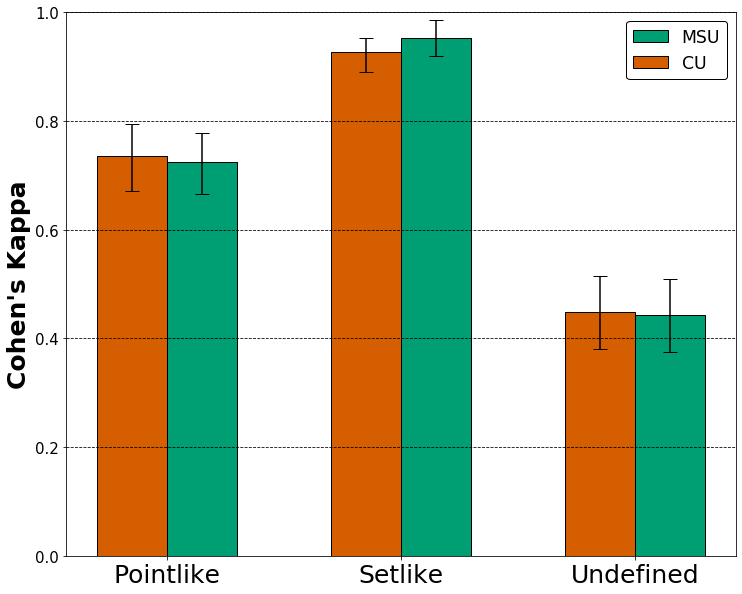

In [25]:
#Visualizing performance of each probe by plotting a bar plot displaying the mean of each probe's Cohen's Kappa with 95% confidence intervals
#MSU first
fig,ax = plt.subplots(figsize=(12,10), sharey=True)
classes = ['P', 'S', 'U']
x_pos = np.arange(0,3,1)
width = .3
#Mean AUCs for each code
print("MSU population")
y_means = np.array([MSU_CU_kappas["RD"].mean(), MSU_CU_kappas["SMDS"].mean(), MSU_CU_kappas["DMSS"].mean()])

print(y_means)
#95% confidence intervals
y_err_min = y_means - np.array([MSU_CU_kappas["RD"].quantile(.025) , MSU_CU_kappas["SMDS"].quantile(.025) , MSU_CU_kappas["DMSS"].quantile(.025)])
y_err_max = np.array([MSU_CU_kappas["RD"].quantile(.975) , MSU_CU_kappas["SMDS"].quantile(.975) , MSU_CU_kappas["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)
    
y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
MSU_rect = ax.bar(x_pos + width/2, y_means, yerr = y_err, width = width, color = "#009E73", edgecolor='black', capsize = 7)

print("CU population")
y_means = np.array([CU_MSU_kappas["RD"].mean(), CU_MSU_kappas["SMDS"].mean(), CU_MSU_kappas["DMSS"].mean()])

print(y_means)
#95% confidence intervals
y_err_min = y_means - np.array([CU_MSU_kappas["RD"].quantile(.025) , CU_MSU_kappas["SMDS"].quantile(.025) , CU_MSU_kappas["DMSS"].quantile(.025)])
y_err_max = np.array([CU_MSU_kappas["RD"].quantile(.975) , CU_MSU_kappas["SMDS"].quantile(.975) , CU_MSU_kappas["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)
    
y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
CU_rect = ax.bar(x_pos - width/2, y_means, yerr = y_err, width = width, color = "#D55E00", edgecolor = "black", capsize = 7)

ax.tick_params(labelsize = 15, grid_color = "black", grid_linestyle = '--')
ax.tick_params(axis = 'x', labelsize = 25)
ax.set_xticks(x_pos)
ax.set_xticklabels(['Pointlike', 'Setlike', 'Undefined'])   
ax.set_ylabel("Cohen's Kappa", fontsize = 25, fontweight = "bold")
ax.legend((MSU_rect, CU_rect), ('MSU','CU'), loc = "upper right", fontsize = 'xx-large', framealpha = 1, edgecolor = "black")
ax.grid(axis = 'y')
    
    
plt.savefig("Average Cohen's Kappa Between Each Model When Tested on Opposite populations")

# Inter-rater reliability, Human - Machine

Shown below is the Cohen's Kappa between the model and human researchers on each population. This figure illustrates the expected reliability between a model and a human researcher when testing on new populations as well as the difference in reliability when using a model trained on the same population as the new population.

CU Model
[0.5316795  0.66130852 0.45288084]
[0.47192616 0.60629808 0.39124722]
[0.59326753 0.71462507 0.51129126]
MSU Model
[0.59111968 0.66896119 0.58934867]
[0.53758782 0.61325348 0.52574344]
[0.64928603 0.72091123 0.65509354]


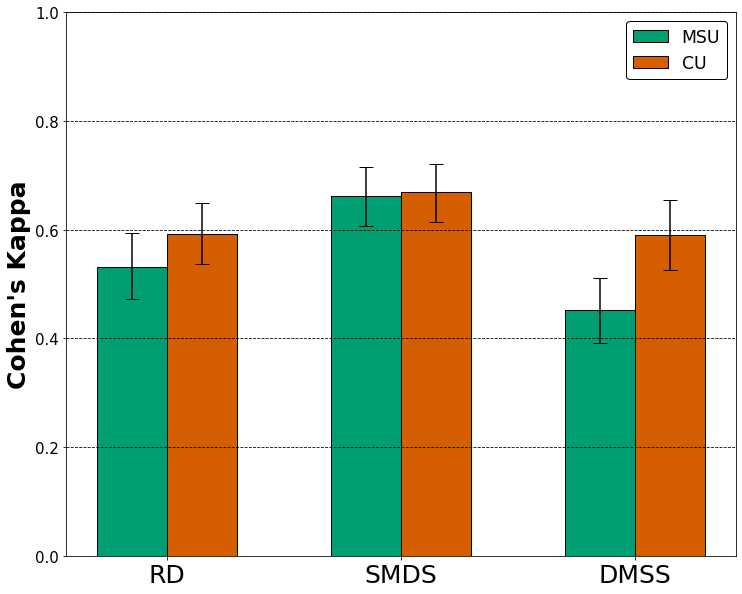

In [26]:
#Comparison with human researcher on MSU population
fig,ax = plt.subplots(figsize=(12,10), sharey=True)
classes = ['P', 'S', 'U']
x_pos = np.arange(0,3,1)
width = .3
#Mean AUCs for each code
print("CU Model")
y_means = np.array([CU_MSU_kappas_H["RD"].mean(), CU_MSU_kappas_H["SMDS"].mean(), CU_MSU_kappas_H["DMSS"].mean()])

print(y_means)
#95% confidence intervals
y_err_min = y_means - np.array([CU_MSU_kappas_H["RD"].quantile(.025) , CU_MSU_kappas_H["SMDS"].quantile(.025) , CU_MSU_kappas_H["DMSS"].quantile(.025)])
y_err_max = np.array([CU_MSU_kappas_H["RD"].quantile(.975) , CU_MSU_kappas_H["SMDS"].quantile(.975) , CU_MSU_kappas_H["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)

y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
MSU_rect = ax.bar(x_pos - width/2, y_means, yerr = y_err, width = width, color = "#009E73", edgecolor='black', capsize = 7)

print("MSU Model")
y_means = np.array([MSU_kappas["RD"].mean(), MSU_kappas["SMDS"].mean(), MSU_kappas["DMSS"].mean()])

print(y_means)

#95% confidence intervals
y_err_min = y_means - np.array([MSU_kappas["RD"].quantile(.025) , MSU_kappas["SMDS"].quantile(.025) , MSU_kappas["DMSS"].quantile(.025)])
y_err_max = np.array([MSU_kappas["RD"].quantile(.975) , MSU_kappas["SMDS"].quantile(.975) , MSU_kappas["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)

y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
CU_rect = ax.bar(x_pos + width/2, y_means, yerr = y_err, width = width, color = "#D55E00", edgecolor = "black", capsize = 7)

ax.tick_params(labelsize = 15, grid_color = "black", grid_linestyle = '--')
ax.tick_params(axis = 'x', labelsize = 25)
ax.set_xticks(x_pos)
ax.set_xticklabels(['RD', 'SMDS', 'DMSS'])
ax.set_ylabel("Cohen's Kappa", fontsize = 25, fontweight = "bold")
ax.legend((MSU_rect, CU_rect), ('MSU','CU'), loc = "upper right", fontsize = 'xx-large', framealpha = 1, edgecolor = "black")
ax.grid(axis = 'y')
    
    
plt.savefig("Average Cohen's Kappa With Human Researcher For Each Model, Tested on MSU population")

MSU Model
[0.5025751  0.78463741 0.46723079]
[0.43389644 0.72977839 0.40939478]
[0.57243276 0.83939699 0.52924728]
CU_model
[0.57843678 0.79228963 0.57308679]
[0.50614762 0.7303446  0.5003885 ]
[0.64513564 0.84696565 0.6428871 ]


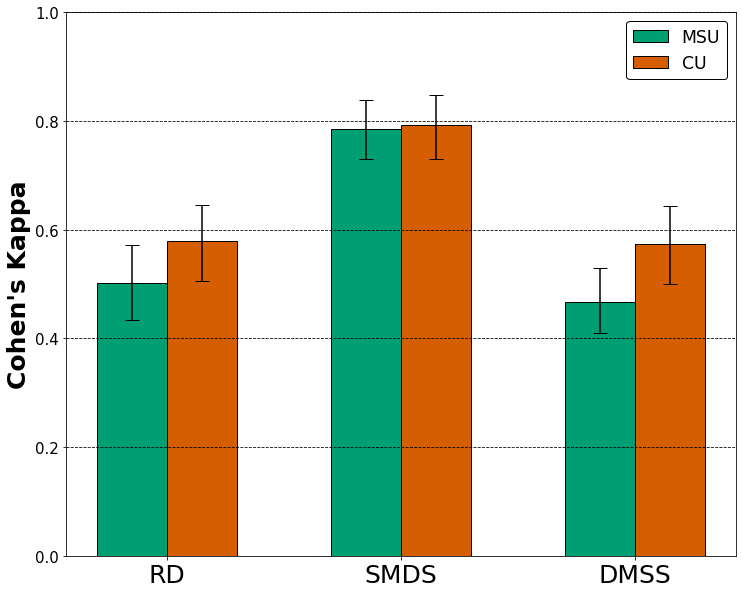

In [27]:
#Comparison with human researcher on CU population
fig,ax = plt.subplots(figsize=(12,10), sharey=True)
classes = ['P', 'S', 'U']
x_pos = np.arange(0,3,1)
width = .3
#Mean AUCs for each code
print("MSU Model")
y_means = np.array([MSU_CU_kappas_H["RD"].mean(), MSU_CU_kappas_H["SMDS"].mean(), MSU_CU_kappas_H["DMSS"].mean()])
print(y_means)
#95% confidence intervals
y_err_min = y_means - np.array([MSU_CU_kappas_H["RD"].quantile(.025) , MSU_CU_kappas_H["SMDS"].quantile(.025) , MSU_CU_kappas_H["DMSS"].quantile(.025)])
y_err_max = np.array([MSU_CU_kappas_H["RD"].quantile(.975) , MSU_CU_kappas_H["SMDS"].quantile(.975) , MSU_CU_kappas_H["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)

y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
MSU_rect = ax.bar(x_pos - width/2, y_means, yerr = y_err, width = width, color = "#009E73", edgecolor='black', capsize = 7)
print("CU_model")
y_means = np.array([CU_kappas["RD"].mean(), CU_kappas["SMDS"].mean(), CU_kappas["DMSS"].mean()])

print(y_means)
#95% confidence intervals
y_err_min = y_means - np.array([CU_kappas["RD"].quantile(.025) , CU_kappas["SMDS"].quantile(.025) , CU_kappas["DMSS"].quantile(.025)])
y_err_max = np.array([CU_kappas["RD"].quantile(.975) , CU_kappas["SMDS"].quantile(.975) , CU_kappas["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)

y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
CU_rect = ax.bar(x_pos + width/2, y_means, yerr = y_err, width = width, color = "#D55E00", edgecolor = "black", capsize = 7)

ax.tick_params(labelsize = 15, grid_color = "black", grid_linestyle = '--')
ax.tick_params(axis = 'x', labelsize = 25)
ax.set_xticks(x_pos)
ax.set_xticklabels(['RD', 'SMDS', 'DMSS']) 
ax.set_ylabel("Cohen's Kappa", fontsize = 25, fontweight = "bold")
ax.legend((MSU_rect, CU_rect), ('MSU','CU'), loc = "upper right", fontsize = 'xx-large', framealpha = 1, edgecolor = "black")
ax.grid(axis = 'y')
    
    
plt.savefig("Average Cohen's Kappa With Human Researcher For Each Model, Tested on CU population")

# Combined 

Here, both datasets were combined and the same framework was used with a 90-10 train-test split on the data. This analysis was done in an attempt to eliminate the effect of imbalanced dataset on the models produced, particularly on the DMSS probe where combining the populations evened out the proportion of point-like to set-like classifications.

In [28]:
FULL_DATA = pd.concat([FULL_DATA_MSU.copy(),FULL_DATA_CU.copy()],axis = 0)

FULL_DATA.head()
len(FULL_DATA)

4371

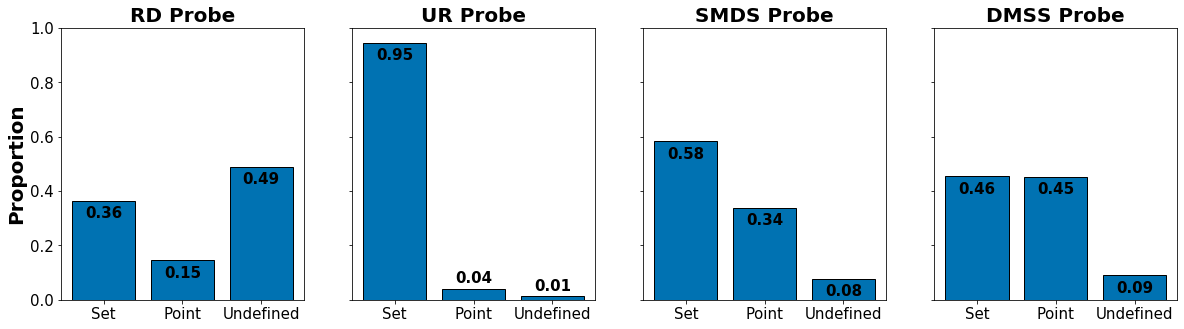

In [29]:
#Visualizing the distribution of coded responses for each probe 
fig,ax = plt.subplots(1,4,figsize=(20,5), sharey=True)
classes = ['S', 'P', 'U']
probe_list = ["RD","UR","SMDS","DMSS"]
for i,probe in enumerate(probe_list):
    x_pos = np.arange(0,3,1)
    width = .8
    #actual
    probe_code = probe + "_Code"
    y_pos = [(list(FULL_DATA[probe_code]).count(c)) / len(FULL_DATA[probe_code]) for c in classes]
    ax[i].set_ylim(0,1)
    rect_act = ax[i].bar(x_pos, y_pos, width, tick_label=['Set-Like', 'Point-Like', 'Undefined'], edgecolor='black', color = "#0072B2")
    if i == 0:
        ax[i].set_ylabel('Proportion', fontsize = 20, fontweight = "bold")
    ax[i].tick_params(labelsize = 15)
    ax[i].set_title(f'{probe} Probe', fontsize = 20, fontweight = "bold")
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(['Set', 'Point', 'Undefined'])
    
    for j, prop in enumerate(y_pos):
        if prop > .06:
            va = 'top'
            offset = -.02
        else:
            va = 'bottom'
            offset = + .01
        ax[i].text(x_pos[j], #X location of proportion
                prop + offset, #Y location
                s=f'{round(prop,2)}', #Required label with formatting
                fontweight = "bold",
                va=va, #Vertical alignment
                ha='center', #Horizontal alignment
                color='black', #Font colour and size
                fontsize=15
                )
    
plt.savefig("Distribution of Coded Student Responses Combined")

In [30]:
iterations = 500             #Number of splits
n_classes = 3               #Number of classifications(P S and U)
FULL_model_dict = {}         #Dictionary containing the model results for each different split of the data

for itr in range(0,iterations):
    FULL_train, FULL_test = train_test_split(FULL_DATA.copy(), test_size=0.1)        #Splits the data into training and testing sets 80-20
                                                                                     #while retaining the classification proportion

    FULL_train = (FULL_train.copy()).reset_index(drop = True) #Resetting indexes that carried over
    FULL_test = (FULL_test.copy()).reset_index(drop = True)

    train_text = clean_text(FULL_train)               #Cleaning the text 
    train_labels = get_labels(FULL_train)             #extracting the classifications from the training set
    train_labels, train_text = clean_nans(train_labels, train_text)  #Missing labels sometimes occur, these are removed in this line
    
    #Do the same for the testing data
    test_text = clean_text(FULL_test)
    test_labels = get_labels(FULL_test)
    test_labels, test_text = clean_nans(test_labels,test_text)

    OVR_models = {}       #Model metric dictionary for current run, added to MSU_model_dict.
    probes = ["RD","SMDS","DMSS"]
    
    #Assigning keys for each metric for each probe.
    for probe in probes:
        OVR_models[probe] = {}

    for probe in probes:
        OVR_models[probe]["TPR"] = {}
        OVR_models[probe]["FPR"] = {}
        OVR_models[probe]["AUC"] = {}

    #Converting the cleaned text data into TF-IDF format
    train_vector, classify_vector,v_dict = train_vectorize(train_text, test_text)
    
    #Training the models for each probe and classifying the testing set using the models.
    classify_dict, models = train_classify_ovr(classify_vector, train_vector, 
                                                   train_labels)

    
    for probe in probes:
        predicted = models[probe].predict_proba(classify_vector[probe])
        OVR_models[probe]["vectorizer"] = v_dict[probe]
        OVR_models[probe]["test_text"] = test_text[probe]
        OVR_models[probe]["Model"] = models[probe]
        OVR_models[probe]["prob_scores"] = np.array(predicted)
        OVR_models[probe]["test_results"] = classify_dict[probe]
        OVR_models[probe]["vocab"] = v_dict[probe].vocabulary_

    #Converting the responses to binary format
    test_labels_binary = {}
    test_labels_binary["RD"] = label_binarize(test_labels["RD"], classes = ['P','S','U']) #Make each label [1,0,0] for P and so on
    test_labels_binary["SMDS"] = label_binarize(test_labels["SMDS"], classes = ['P','S','U'])
    test_labels_binary["DMSS"] = label_binarize(test_labels["DMSS"], classes = ['P','S','U'])
    
    #Compute the TPR and FPR achieved by varying the decision threshold for each classification's ROC curve
    for probe in probes:
        test_scores = OVR_models[probe]['prob_scores']
        OVR_models[probe]["test_labels"] = test_labels_binary[probe]
        OVR_models[probe]["test_labels_nb"] = test_labels[probe]
        for i,code in [(0,'P'), (1,'S'), (2,'U')]:
            OVR_models[probe]["FPR"][code], OVR_models[probe]["TPR"][code], _ = roc_curve(test_labels_binary[probe][:,i], test_scores[:, i])
            OVR_models[probe]["AUC"][code] = auc(OVR_models[probe]["FPR"][code], OVR_models[probe]["TPR"][code])
        
        #Computing the micro FPR, TPR, and auc by raveling the labels and decision probabilities together
        OVR_models[probe]["FPR"]["micro"], OVR_models[probe]["TPR"]["micro"], _ = roc_curve(test_labels_binary[probe].ravel(), test_scores.ravel())
        OVR_models[probe]["AUC"]["micro"] = auc(OVR_models[probe]["FPR"]["micro"], OVR_models[probe]["TPR"]["micro"])
    
        #Computing the macro auc 
        #First concatenate the entire FPR space across each classification
        combined_fpr = np.unique(np.concatenate([OVR_models[probe]["FPR"][code] for code in ['P','S','U']]))

        #Then linearly interpolate the TPRs for each classification to the new FPR space
        mean_tpr = np.zeros_like(combined_fpr)
        for code in ['P','S','U']:
            mean_tpr += np.interp(combined_fpr, OVR_models[probe]["FPR"][code], OVR_models[probe]["TPR"][code])

        #Finally average it and compute macro AUC
        mean_tpr /= n_classes
        
        OVR_models[probe]["FPR"]["macro"] = combined_fpr
        OVR_models[probe]["TPR"]["macro"] = mean_tpr
        
        OVR_models[probe]["AUC"]["macro"] = auc(OVR_models[probe]["FPR"]["macro"],OVR_models[probe]["TPR"]["macro"])
        
        #Compute accuracy and cohen's kappa for each probe
        
        #First compute the confusion matrix, M[i,j] is how many i classifications are predicted to be j. 0:P, 1:S, 2:U
        #test_results_binary = label_binarize(OVR_models[probe]["test_results"], classes = ['P','S','U'])
        conf_matr = confusion_matrix(test_labels[probe],OVR_models[probe]["test_results"],labels = ['P','S','U'])
        
        #Accuracy is just the trace divided by the lump sum of each entry
        N = np.sum(conf_matr.ravel())
        TP = np.trace(conf_matr)
        OVR_models[probe]["Acc"] = TP / N
        
        #Calculating the estimated chance agreement
        C = 0
        for i in range(len(conf_matr)):
            N_i = conf_matr[i,:].sum()  #Number of classifications
            P_i = conf_matr[:,i].sum()  #Number of predicted classifications
            C += N_i/N * P_i/N          #ith term of chance agreement
            
        K = ( (TP / N) - C ) / ( 1 - C )
        OVR_models[probe]["Kappa"] = K
        
            
        
        
        
        
        
    FULL_model_dict[itr] = OVR_models
    if itr%10 == 0:
        print(f"Progress: {itr}/{iterations}")
    
#Collecting the cohen kappas and micro, P, S, and U aucs for each probe and converting into pandas series objects
FULL_kappas = {}
FULL_micros = {}
FULL_P = {}
FULL_S = {}
FULL_U = {}

for probe in probes:
    kappas = []
    micros = []
    P = []
    S = []
    U = []
    for itr in range(0,iterations):
        kappas.append(FULL_model_dict[itr][probe]["Kappa"])
        micros.append(FULL_model_dict[itr][probe]["AUC"]["micro"])
        P.append(FULL_model_dict[itr][probe]["AUC"]["P"])
        S.append(FULL_model_dict[itr][probe]["AUC"]["S"])
        U.append(FULL_model_dict[itr][probe]["AUC"]["U"])
        
    FULL_kappas[probe] = pd.Series(kappas)
    FULL_micros[probe] = pd.Series(micros)
    FULL_P[probe] = pd.Series(P)
    FULL_S[probe] = pd.Series(S)
    FULL_U[probe] = pd.Series(U)

Progress: 0/500
Progress: 10/500
Progress: 20/500
Progress: 30/500
Progress: 40/500
Progress: 50/500
Progress: 60/500
Progress: 70/500
Progress: 80/500
Progress: 90/500
Progress: 100/500
Progress: 110/500
Progress: 120/500
Progress: 130/500
Progress: 140/500
Progress: 150/500
Progress: 160/500
Progress: 170/500
Progress: 180/500
Progress: 190/500
Progress: 200/500
Progress: 210/500
Progress: 220/500
Progress: 230/500
Progress: 240/500
Progress: 250/500
Progress: 260/500
Progress: 270/500
Progress: 280/500
Progress: 290/500
Progress: 300/500
Progress: 310/500
Progress: 320/500
Progress: 330/500
Progress: 340/500
Progress: 350/500
Progress: 360/500
Progress: 370/500
Progress: 380/500
Progress: 390/500
Progress: 400/500
Progress: 410/500
Progress: 420/500
Progress: 430/500
Progress: 440/500
Progress: 450/500
Progress: 460/500
Progress: 470/500
Progress: 480/500
Progress: 490/500


RD
FULL
[0.90951239 0.93600991 0.87868682]
[0.88037687 0.9142314  0.84637152]
[0.93864907 0.95551526 0.90823818]
RD
MSU
[0.8981482  0.9371542  0.88762953]
[0.86236873 0.91524159 0.85964306]
[0.92829207 0.95827582 0.91314985]
CU
[0.90849165 0.92999192 0.86368986]
[0.87263997 0.90498982 0.82940897]
[0.93914177 0.95176203 0.89409023]
SMDS
FULL
[0.94476608 0.96460359 0.80686356]
[0.92182388 0.94557562 0.73526237]
[0.96429713 0.97912858 0.88035714]
SMDS
MSU
[0.92158216 0.95802124 0.82516381]
[0.90007174 0.94220733 0.76723827]
[0.94175395 0.97225853 0.87672664]
CU
[0.96761031 0.97048787 0.75067868]
[0.94809394 0.95015935 0.62805769]
[0.98367452 0.98764436 0.86173926]
DMSS
FULL
[0.92576392 0.93368165 0.80501703]
[0.90187604 0.911506   0.72715474]
[0.94795209 0.95352141 0.86902549]
DMSS
MSU
[0.91062037 0.94570995 0.81238743]
[0.88589174 0.92714545 0.75016437]
[0.94017079 0.96375108 0.86904954]
CU
[0.92719781 0.91932812 0.85038961]
[0.90282392 0.89321468 0.79180492]
[0.95169143 0.94189663 0.906

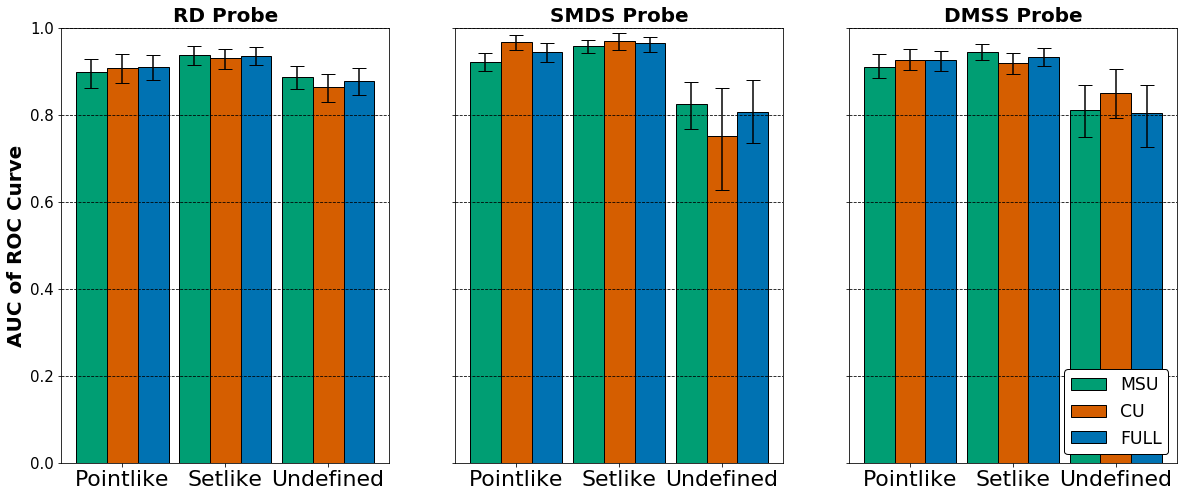

In [31]:
#Visualizing performance of each probe by plotting a bar plot displaying the mean of each code's AUC with 95% confidence intervals
#MSU first
fig,ax = plt.subplots(1,3,figsize=(20,8), sharey=True)
classes = ['P', 'S', 'U']
probe_list = ["RD","SMDS","DMSS"]
for i,probe in enumerate(probe_list):
    x_pos = np.arange(0,3,1)
    width = .3
    #Mean AUCs for each code
    y_means = np.array([FULL_P[probe].mean(), FULL_S[probe].mean(), FULL_U[probe].mean()])
    
    print(probe)
    print("FULL")
    print(y_means)
    #95% confidence intervals
    y_err_min = y_means - np.array([FULL_P[probe].quantile(.025) , FULL_S[probe].quantile(.025) , FULL_U[probe].quantile(.025)])
    y_err_max = np.array([FULL_P[probe].quantile(.975) , FULL_S[probe].quantile(.975) , FULL_U[probe].quantile(.975)]) - y_means
    
    print(y_means - y_err_min)
    print(y_means + y_err_max)
    
    y_err = [y_err_min , y_err_max]
    ax[i].set_ylim(0,1)
    FULL_rect = ax[i].bar(x_pos + width, y_means, yerr = y_err, width = width, color = "#0072B2", edgecolor='black', capsize = 7)

    
    y_means = np.array([MSU_P[probe].mean(), MSU_S[probe].mean(), MSU_U[probe].mean()])
    
    print(probe)
    print("MSU")
    print(y_means)
    #95% confidence intervals
    y_err_min = y_means - np.array([MSU_P[probe].quantile(.025) , MSU_S[probe].quantile(.025) , MSU_U[probe].quantile(.025)])
    y_err_max = np.array([MSU_P[probe].quantile(.975) , MSU_S[probe].quantile(.975) , MSU_U[probe].quantile(.975)]) - y_means
    
    print(y_means - y_err_min)
    print(y_means + y_err_max)
    
    y_err = [y_err_min , y_err_max]
    ax[i].set_ylim(0,1)
    MSU_rect = ax[i].bar(x_pos - width, y_means, yerr = y_err, width = width, color = "#009E73", edgecolor='black', capsize = 7)
    
    y_means = np.array([CU_P[probe].mean(), CU_S[probe].mean(), CU_U[probe].mean()])
    
    print("CU")
    print(y_means)
    #95% confidence intervals
    y_err_min = y_means - np.array([CU_P[probe].quantile(.025) , CU_S[probe].quantile(.025) , CU_U[probe].quantile(.025)])
    y_err_max = np.array([CU_P[probe].quantile(.975) , CU_S[probe].quantile(.975) , CU_U[probe].quantile(.975)]) - y_means
    
    print(y_means - y_err_min)
    print(y_means + y_err_max)
    
    y_err = [y_err_min , y_err_max]
    ax[i].set_ylim(0,1)
    CU_rect = ax[i].bar(x_pos, y_means, yerr = y_err, width = width, color = "#D55E00", edgecolor = "black", capsize = 7)
    ax[i].tick_params(labelsize = 15, grid_color = "black", grid_linestyle = '--')
    ax[i].tick_params(axis = 'x', labelsize = 22)
    ax[i].set_title(f'{probe} Probe', fontsize = 20, fontweight = "bold")
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(['Pointlike', 'Setlike', 'Undefined'])
    
    if i == 0:
        ax[i].set_ylabel('AUC of ROC Curve', fontsize = 20, fontweight = "bold")
    elif i == 2:
        ax[i].legend((MSU_rect, CU_rect, FULL_rect), ('MSU','CU','FULL'), loc = "lower right", fontsize = 'xx-large', framealpha = 1, edgecolor = "black")
        
    ax[i].grid(axis = 'y')
    
plt.savefig("Average AUCs of Each Model When Trained and Tested on Corresponding Populations Combined")    


MSU
[0.59111968 0.66896119 0.58934867]
[0.53758782 0.61325348 0.52574344]
[0.64928603 0.72091123 0.65509354]
FULL
[0.60469633 0.72564294 0.64263341]
[0.54651561 0.6694929  0.58143572]
[0.66328474 0.78010884 0.70166022]
CU
[0.57843678 0.79228963 0.57308679]
[0.50614762 0.7303446  0.5003885 ]
[0.64513564 0.84696565 0.6428871 ]


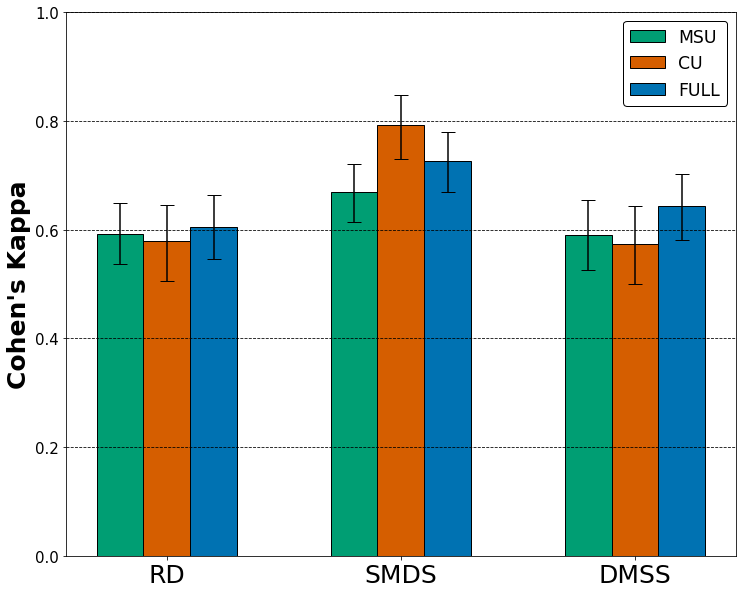

In [32]:
#Visualizing performance of each probe by plotting a bar plot displaying the mean of each probe's Cohen's Kappa with 95% confidence intervals
#MSU first
fig,ax = plt.subplots(figsize=(12,10), sharey=True)
classes = ['P', 'S', 'U']
x_pos = np.arange(0,3,1)
width = .2
#Mean AUCs for each code
y_means = np.array([MSU_kappas["RD"].mean(), MSU_kappas["SMDS"].mean(), MSU_kappas["DMSS"].mean()])

print("MSU")
print(y_means)

#95% confidence intervals
y_err_min = y_means - np.array([MSU_kappas["RD"].quantile(.025) , MSU_kappas["SMDS"].quantile(.025) , MSU_kappas["DMSS"].quantile(.025)])
y_err_max = np.array([MSU_kappas["RD"].quantile(.975) , MSU_kappas["SMDS"].quantile(.975) , MSU_kappas["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)

y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
MSU_rect = ax.bar(x_pos - width, y_means, yerr = y_err, width = width, color = "#009E73", edgecolor='black', capsize = 7)


y_means = np.array([FULL_kappas["RD"].mean(), FULL_kappas["SMDS"].mean(), FULL_kappas["DMSS"].mean()])

print("FULL")
print(y_means)

#95% confidence intervals
y_err_min = y_means - np.array([FULL_kappas["RD"].quantile(.025) , FULL_kappas["SMDS"].quantile(.025) , FULL_kappas["DMSS"].quantile(.025)])
y_err_max = np.array([FULL_kappas["RD"].quantile(.975) , FULL_kappas["SMDS"].quantile(.975) , FULL_kappas["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)

y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
FULL_rect = ax.bar(x_pos + width, y_means, yerr = y_err, width = width, color = "#0072B2", edgecolor='black', capsize = 7)

y_means = np.array([CU_kappas["RD"].mean(), CU_kappas["SMDS"].mean(), CU_kappas["DMSS"].mean()])

print("CU")
print(y_means)

#95% confidence intervals
y_err_min = y_means - np.array([CU_kappas["RD"].quantile(.025) , CU_kappas["SMDS"].quantile(.025) , CU_kappas["DMSS"].quantile(.025)])
y_err_max = np.array([CU_kappas["RD"].quantile(.975) , CU_kappas["SMDS"].quantile(.975) , CU_kappas["DMSS"].quantile(.975)]) - y_means

print(y_means - y_err_min)
print(y_means + y_err_max)

y_err = [y_err_min , y_err_max]
ax.set_ylim(0,1)
CU_rect = ax.bar(x_pos, y_means, yerr = y_err, width = width, color = "#D55E00", edgecolor = "black", capsize = 7)

ax.tick_params(labelsize = 15, grid_color = "black", grid_linestyle = '--')
ax.tick_params(axis = 'x', labelsize = 25)
ax.set_xticks(x_pos)
ax.set_xticklabels(['RD', 'SMDS', 'DMSS'])
ax.set_ylabel("Cohen's Kappa", fontsize = 25, fontweight = "bold")
ax.legend((MSU_rect, CU_rect, FULL_rect), ('MSU','CU', "FULL"), loc = "upper right", fontsize = 'xx-large', framealpha = 1, edgecolor = "black")
ax.grid(axis = 'y')


    
    
plt.savefig("Average Cohen's Kappa with Human Researcher For Each Model, Trained and Tested on Corresponding Populations 2")

##### 